In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import KFold

from model_tree import *
from reg_tree import *

from os import listdir
from os.path import isfile, join

# online source :https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

data_path = "../../../../machine learning/checkdatasets/PRSA_Data_20130301-20170228/"


files = [f for f in listdir(data_path)]

frames= []
for file in files:
    if file[-4:] == ".csv" :
        d = pd.read_csv(data_path+file)
        frames.append(d)

df = pd.concat(frames)

# only predict O3
df=df.drop(columns=['No','PM2.5', 'PM10', 'SO2', 'NO2', 'CO'])

# for coding purpose, use a smaller dataset; otherwise, just shuffle with frac=1
df=df.sample(frac=1)

# get attributes columns 
attributes = list(df.columns).copy()
attributes.remove('O3')

# drop every row having a missing value in O3, our target, or in station (we do not know from where the data comes from)
df.dropna(subset=["O3","station"], inplace=True)

df_origin = df.copy()

df.head()

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
8603,2014,2,22,11,22.000,5.2,1027.1,-3.4,0.0,NE,1.3,Shunyi
2690,2013,6,21,2,2.000,22.8,1006.1,18.8,0.0,NE,1.2,Shunyi
31413,2016,9,29,21,2.000,15.8,1013.7,9.2,0.0,NNE,1.3,Shunyi
15226,2014,11,25,10,6.000,3.0,1021.0,-2.3,0.0,SE,0.5,Tiantan
6119,2013,11,10,23,14.994,2.3,1026.5,-10.6,0.0,NNE,1.1,Shunyi


In [2]:
# returns a table with the percentage of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d
number_of_samples_per_number_of_missing_values(df).map(lambda x: x/len(df))

0    0.995470
1    0.003561
2    0.000022
4    0.000182
5    0.000020
6    0.000746
Name: missing values in row, dtype: float64

In [3]:
# returns a table with the percentage of missing values per attribute

df.isna().sum().map(lambda x: x/len(df))

year       0.000000
month      0.000000
day        0.000000
hour       0.000000
O3         0.000000
TEMP       0.000960
PRES       0.000947
DEWP       0.000972
RAIN       0.000940
wd         0.004319
WSPM       0.000768
station    0.000000
dtype: float64

In [4]:
df.describe() 

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,407491.000000,407491.000000,407491.000000,407491.000000,407491.000000,407100.000000,407105.000000,407095.000000,407108.000000,407178.000000
mean,2014.672152,6.502355,15.728902,11.543666,57.372271,13.589864,1010.711416,2.489784,0.065201,1.736377
std,1.175809,3.443240,8.798008,6.918263,56.661607,11.436452,10.471908,13.823238,0.828276,1.249161
min,2013.000000,1.000000,1.000000,0.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,6.000000,11.000000,3.200000,1002.200000,-9.000000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,12.000000,45.000000,14.600000,1010.300000,3.100000,0.000000,1.400000
75%,2016.000000,9.000000,23.000000,18.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


We can see that our dataset has relatively a small amount of missing values, so we will delete the missing values (we can assume that these values are Missing Completely at Random, ie the fact that the value is missing has nothing to do with its hypothetical value and with the values of other variables, because here we it is just a lack of data due to weather station and we can suppose that no bias is introduced if we drop rows with missing values.
To be sure of this assumption, we will try with the total deletion of the rows with missing values (here printed for the preprocessing), and then with a threshold of 3 missing values at most for a row, and finally with an imputation for everything.
We will use two kind of preprocessing: mean value (and most common value for non numeral values) and 5NN.

# Preprocessing

In [5]:
from sklearn.impute import KNNImputer

# drop rows with missing values

def dropRows(df, wds=[], thres=0, imputation=None) :
    
    if imputation == "mean" :
        # wind direction is nominal so we have to check for every created column (wds)
        for wd in wds :
            df[wd] = df[wd].fillna(df[wd].mode()[0])
        # for numeral values
        missing_list = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
        for name in missing_list:
            df[name] = df[name].fillna(df[name].mean())
        return df
    elif imputation == "5NN" :
        imp = KNNImputer(n_neighbors=5)
        # we fit the multivariate feature imputation
        imp.fit(df)
        # we use it on training dataset
        array = imp.transform(df)
        return pd.DataFrame(array, columns = df.columns)
    else :
        return df.dropna(thresh=len(df.columns)-thres)
    
df = dropRows(df)

<Figure size 432x288 with 0 Axes>

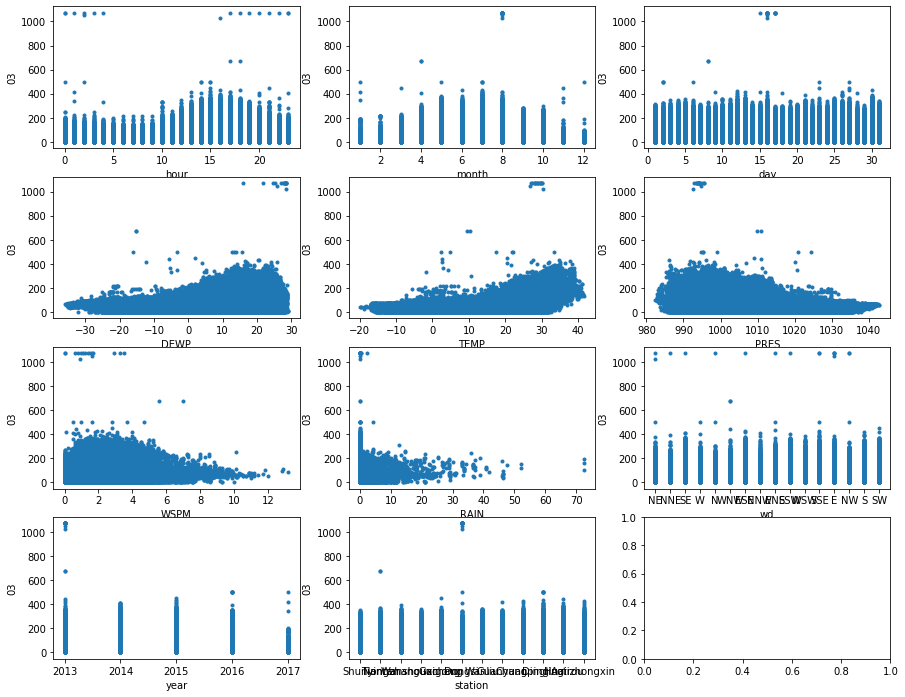

In [6]:
# plots scatter graph with the mean value of the target for each value of the attribute (string imput)
# log is true when we want to plot it with a logarithmic scale

def plotTargetPerAttribute(data, attribute, ax=plt, logx=False, logy=False) :
    if logx :
        ax.semilogx(data[attribute], data["O3"])
    elif logy :
        ax.semilogy(data[attribute], data["O3"])
    else :
        ax.plot(data[attribute], data["O3"], '.')
    ax.set(xlabel=attribute)
    ax.set(ylabel="03")
    #ax.savefig("./max_iter_ppn.pdf")

def plotAllAttributes(data) :
    plt.clf()
    fig, axs = plt.subplots(4,3, figsize = (15,12))
    j = -1
    for i in range(11) :
        attribute = attributes[i]
        plotTargetPerAttribute(data, attribute, axs[j][i%3])
        if i%3 == 0:
            j += 1
    plt.savefig("../figures/airquality/plot_all_attributes.jpeg")

plotAllAttributes(df)

In [7]:
def removeOutliers(df) :
    if 'O3' in df.columns :
        df = df[df['O3'] < 1000]
    return df

from sklearn.preprocessing import MinMaxScaler

# scaling with min-max, useful only for KNN imputation

def scaling(df) :
    num_columns = ["year","month","day","hour","TEMP","PRES","DEWP","RAIN","WSPM"]
    scaler = MinMaxScaler()
    df_num = df[num_columns]
    df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=num_columns)
    for col in num_columns:
        df[col] = df_num[col]
    return df
    
# get the O3 index
indO3 = None

# returns the 5 datasets with the 5 methods of preprocessing

def preprocessing(df) :
    # encode columns by one hot
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    removeOutliers(df)
    df = scaling(df)

    df1 = dropRows(df, thres=0, imputation=None)
    df2 = dropRows(df, wds=wds, thres=4, imputation="mean")
    df3 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="mean")
    df4 = dropRows(df, wds=wds, thres=4, imputation="5NN")
    df5 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="5NN")
    DF = [df1,df2,df3,df4,df5]
    for i in range(len(DF)) :
        DF[i] = np.array(DF[i]).astype("float")
    return DF
 
def preprocessing_mean(df) :
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    df = dropRows(df, thres=(len(df_origin)-1), imputation="mean")
    df = removeOutliers(df)
    return np.array(df).astype("float")

In [8]:
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2 = [[] for i in range(5)], [[] for i in range(5)]
M5regressor_MAE_model, const_regressor_MAE = [[] for i in range(5)], [[] for i in range(5)]

# We split the data and apply the pre-processing

for train_index, test_index in split:
        array_train = df_origin.iloc[train_index]
        array_test = df_origin.iloc[test_index]
        
        trains = preprocessing(pd.DataFrame(data=array_train, columns=df_origin.columns))
        tests = preprocessing(pd.DataFrame(data=array_test, columns=df_origin.columns))

        for i in range(5) :
            y_train = trains[i][:,indO3]
            y_test = tests[i][:,indO3]
            X_train = np.delete(trains[i], indO3, axis=1)
            X_test = np.delete(tests[i], indO3, axis=1)
            
            #M5 regressor tree own
            reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
            M5regressor_r2_model[i].append(r2_score(y_test, reg.predict(X_test)))
            M5regressor_MAE_model[i].append(mean_absolute_error(y_test, reg.predict(X_test)))

            #Constant regressor tree own
            reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
            const_regressor_r2[i].append(r2_score(y_test, reg2.predict(X_test)))
            const_regressor_MAE[i].append(mean_absolute_error(y_test, reg2.predict(X_test)))
            
m5_r2, cons_r2 = [], []
for i in range(5):
    m5_r2.append(np.mean(M5regressor_r2_model[i]))
    cons_r2.append(np.mean(const_regressor_r2[i]))

print("m5_r2:", m5_r2)
print("cons_r2:", cons_r2)

calc split of 271396 points
dim, split 5 0.9800332778702163
calc split of 271381 points
dim, split 3 0.7826086956521738
calc split of 203219 points
dim, split 5 0.12146422628951825
calc split of 1634 points
dim, split 8 0.6212121212121212
calc split of 1626 points
dim, split 4 0.7707317073170732
calc split of 8 points
calc split of 201585 points
dim, split 6 0.740399385560676
calc split of 136337 points
dim, split 7 0.06344827586206896
calc split of 65248 points
dim, split 8 0.05303030303030303
calc split of 68162 points
dim, split 6 0.9861751152073733
calc split of 68145 points
dim, split 4 0.8406504065040651
calc split of 66999 points
dim, split 7 0.03862068965517241
calc split of 1146 points
dim, split 4 0.8975609756097561
calc split of 17 points
calc split of 15 points
calc split of 271396 points
calc split of 271381 points
calc split of 203219 points
calc split of 1634 points
calc split of 1626 points
calc split of 801 points
calc split of 683 points
calc split of 677 points
calc 

calc split of 49 points
calc split of 9 points
Make it a leaf backup
calc split of 40 points
calc split of 51 points
calc split of 18 points
Make it a leaf backup
calc split of 33 points
calc split of 24 points
calc split of 9 points
Make it a leaf backup
calc split of 1146 points
calc split of 1097 points
calc split of 1023 points
calc split of 31 points
calc split of 24 points
calc split of 7 points
Make it a leaf backup
calc split of 992 points
calc split of 755 points
calc split of 237 points
calc split of 74 points
calc split of 59 points
calc split of 47 points
calc split of 12 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 49 points
calc split of 41 points
calc split of 25 points
calc split of 15 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 15 points
Make it a

calc split of 91694 points
calc split of 89449 points
calc split of 32726 points
calc split of 9 points
Make it a leaf backup
calc split of 32717 points
calc split of 28804 points
calc split of 3913 points
calc split of 56723 points
calc split of 27417 points
calc split of 10 points
Make it a leaf backup
calc split of 27407 points
calc split of 29306 points
calc split of 23514 points
calc split of 5792 points
calc split of 2245 points
calc split of 374 points
calc split of 39 points
calc split of 28 points
calc split of 11 points
Make it a leaf backup
calc split of 335 points
calc split of 32 points
calc split of 303 points
calc split of 1871 points
calc split of 185 points
calc split of 98 points
calc split of 87 points
calc split of 1686 points
calc split of 151 points
calc split of 1535 points
calc split of 37479 points
calc split of 35534 points
calc split of 1350 points
calc split of 112 points
calc split of 98 points
calc split of 14 points
Make it a leaf backup
calc split of 123

calc split of 1361 points
calc split of 149 points
calc split of 418 points
calc split of 76 points
calc split of 342 points
calc split of 131626 points
calc split of 9960 points
calc split of 9926 points
calc split of 9917 points
calc split of 9591 points
calc split of 9446 points
calc split of 145 points
calc split of 326 points
calc split of 163 points
calc split of 163 points
calc split of 9 points
Make it a leaf backup
calc split of 34 points
calc split of 14 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 121666 points
calc split of 120370 points
calc split of 4787 points
calc split of 4724 points
calc split of 2131 points
calc split of 2593 points
calc split of 63 points
calc split of 34 points
calc split of 29 points
calc split of 115583 points
calc split of 115546 points
calc split of 27549 points
calc split of 87997 points
calc split of 37 points
calc split of 16 points
Make it a leaf backup
calc split of 21 points
calc split of 1296 p

calc split of 10652 points
calc split of 515 points
calc split of 396 points
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 373 points
calc split of 329 points
calc split of 135 points
calc split of 94 points
calc split of 41 points
calc split of 194 points
calc split of 97 points
calc split of 97 points
calc split of 44 points
calc split of 17 points
Make it a leaf backup
calc split of 27 points
calc split of 18 points
calc split of 9 points
Make it a leaf backup
calc split of 119 points
calc split of 83 points
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 60 points
calc split of 28 points
calc split of 15 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 32 points
calc split of 15 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 36 points
calc 

calc split of 184 points
calc split of 65 points
calc split of 119 points
calc split of 6 points
Make it a leaf backup
calc split of 473 points
calc split of 306 points
calc split of 75 points
calc split of 11 points
Make it a leaf backup
calc split of 64 points
calc split of 231 points
calc split of 81 points
calc split of 150 points
calc split of 167 points
calc split of 18 points
Make it a leaf backup
calc split of 149 points
calc split of 79 points
calc split of 70 points
calc split of 1192 points
calc split of 376 points
calc split of 345 points
calc split of 29 points
calc split of 8 points
Make it a leaf backup
calc split of 21 points
calc split of 316 points
calc split of 150 points
calc split of 166 points
calc split of 31 points
calc split of 12 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 816 points
calc split of 313 points
calc split of 7 points
Make it a leaf backup
calc split of 306 points
calc split of 266 points
calc split of 

dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 43506 points
dim, split 5 0.829470198675498
calc split of 101924 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 9 points
calc split of 87990 points
dim, split 4 0.2995934959349594
calc split of 2279 points
dim, split 5 0.6390728476821224
calc split of 85711 points
dim, split 7 0.028965517241379312
calc split of 125021 points
dim, split 6 0.9710344827586206
calc split of 124882 points
dim, split 1 0.36363636363636365
calc split of 41272 points
dim, split 5 0.796357615894042
calc split of 39913 points
dim, split 7 0.0027586206896551726
calc split of 1359 points
dim, split 0 0.25
calc split of 83610 points
dim, split 3 0.9130434782608695
calc split of 60868 points
dim, split 1 0.4545454545454545
calc split of 22742 points
dim, split 4 0.8666666666666667
calc split of 139 points

calc split of 52877 points
calc split of 52368 points
calc split of 51800 points
calc split of 568 points
calc split of 509 points
calc split of 419 points
calc split of 90 points
calc split of 9 points
Make it a leaf backup
calc split of 22742 points
calc split of 22726 points
calc split of 2940 points
calc split of 66 points
calc split of 8 points
Make it a leaf backup
calc split of 58 points
calc split of 2874 points
calc split of 760 points
calc split of 2114 points
calc split of 19786 points
calc split of 19756 points
calc split of 1052 points
calc split of 18704 points
calc split of 30 points
calc split of 8 points
Make it a leaf backup
calc split of 22 points
calc split of 16 points
Make it a leaf backup
calc split of 139 points
calc split of 72 points
calc split of 47 points
calc split of 26 points
calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 25 points
calc split of 8 poin

calc split of 41404 points
calc split of 40045 points
calc split of 39553 points
calc split of 4093 points
calc split of 4083 points
calc split of 3952 points
calc split of 131 points
calc split of 10 points
Make it a leaf backup
calc split of 35460 points
calc split of 26251 points
calc split of 245 points
calc split of 26006 points
calc split of 9209 points
calc split of 429 points
calc split of 8780 points
calc split of 492 points
calc split of 49 points
calc split of 32 points
calc split of 23 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 443 points
calc split of 19 points
Make it a leaf backup
calc split of 424 points
calc split of 46 points
calc split of 378 points
calc split of 1359 points
calc split of 22 points
calc split of 10 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 1337 points
calc split of 1264 points
calc split of 496 points
calc split of

calc split of 17 points
Make it a leaf backup
calc split of 49 points
calc split of 35 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 43514 points
calc split of 43294 points
calc split of 42516 points
calc split of 42443 points
calc split of 42023 points
calc split of 420 points
calc split of 73 points
calc split of 9 points
Make it a leaf backup
calc split of 64 points
calc split of 778 points
calc split of 654 points
calc split of 567 points
calc split of 87 points
calc split of 124 points
calc split of 30 points
calc split of 94 points
calc split of 220 points
calc split of 26 points
Make it a leaf backup
calc split of 194 points
calc split of 97 points
calc split of 6 points
Make it a leaf backup
calc split of 91 points
calc split of 97 points
calc split of 88 points
calc split of 9 points
Make it a leaf 

calc split of 87 points
calc split of 16 points
Make it a leaf backup
calc split of 71 points
calc split of 10 points
Make it a leaf backup
calc split of 826 points
calc split of 452 points
calc split of 374 points
calc split of 76898 points
calc split of 41330 points
calc split of 18132 points
calc split of 10419 points
calc split of 3965 points
calc split of 2271 points
calc split of 1347 points
calc split of 924 points
calc split of 1694 points
calc split of 1076 points
calc split of 618 points
calc split of 6454 points
calc split of 3863 points
calc split of 1067 points
calc split of 2796 points
calc split of 2591 points
calc split of 1622 points
calc split of 969 points
calc split of 7713 points
calc split of 3390 points
calc split of 423 points
calc split of 198 points
calc split of 225 points
calc split of 2967 points
calc split of 561 points
calc split of 2406 points
calc split of 4323 points
calc split of 2667 points
calc split of 1565 points
calc split of 1102 points
calc spl

# Parameters tuning

We can notice that the difference can be ignored, so we will use the mean without deleting any value.

# Constant regressor tree

calc split of 271661 points
calc split of 146475 points
calc split of 44445 points
calc split of 657 points
calc split of 439 points
calc split of 218 points
calc split of 43788 points
calc split of 274 points
calc split of 43514 points
calc split of 102030 points
calc split of 13934 points
calc split of 13925 points
calc split of 9 points
Make it a leaf backup
calc split of 88096 points
calc split of 2279 points
calc split of 85817 points
calc split of 125186 points
calc split of 125047 points
calc split of 41404 points
calc split of 40045 points
calc split of 1359 points
calc split of 83643 points
calc split of 60890 points
calc split of 22753 points
calc split of 139 points
calc split of 72 points
calc split of 47 points
calc split of 25 points
calc split of 67 points
calc split of 30 points
calc split of 37 points
calc split of 271661 points
calc split of 146475 points
calc split of 44445 points
calc split of 657 points
calc split of 439 points
calc split of 275 points
calc split o

Make it a leaf backup
calc split of 22 points
calc split of 13 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 43788 points
calc split of 274 points
calc split of 225 points
calc split of 16 points
Make it a leaf backup
calc split of 209 points
calc split of 123 points
calc split of 104 points
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 80 points
calc split of 67 points
calc split of 13 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 86 points
calc split of 69 points
calc split of 60 points
calc split of 17 points
Make it a leaf backup
calc split of 43 points
calc split of 9 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 49 points
calc split of 35 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 

calc split of 8 points
Make it a leaf backup
calc split of 85746 points
calc split of 83695 points
calc split of 80372 points
calc split of 79028 points
calc split of 75348 points
calc split of 3680 points
calc split of 1344 points
calc split of 17 points
Make it a leaf backup
calc split of 1327 points
calc split of 3323 points
calc split of 3223 points
calc split of 20 points
Make it a leaf backup
calc split of 3203 points
calc split of 100 points
calc split of 74 points
calc split of 26 points
Make it a leaf backup
calc split of 2051 points
calc split of 1676 points
calc split of 1383 points
calc split of 25 points
calc split of 1358 points
calc split of 293 points
calc split of 248 points
calc split of 45 points
calc split of 375 points
calc split of 130 points
calc split of 65 points
calc split of 65 points
calc split of 245 points
calc split of 235 points
calc split of 10 points
Make it a leaf backup
calc split of 125186 points
calc split of 125047 points
calc split of 41404 point

calc split of 57 points
calc split of 49 points
calc split of 40 points
calc split of 8 points
Make it a leaf backup
calc split of 32 points
calc split of 15 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 120 points
calc split of 109 points
calc split of 29 points
calc split of 5 points
Make it a leaf backup
calc split of 24 points
calc split of 10 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 80 points
calc split of 50 points
calc split of 39 points
calc split of 5 points
Make it a leaf backup
calc split of 34 points
calc split of 11 points
Make it a leaf backup
calc split of 30 points
calc split of 9 points
Make it a leaf backup
calc split of 21 points
calc split of 8 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 164 points


calc split of 7 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 94 points
calc split of 22 points
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 72 points
calc split of 60 points
calc split of 7 points
Make it a leaf backup
calc split of 53 points
calc split of 30 points
calc split of 22 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 220 points
calc split of 26 points
Make it a leaf backup
calc split of 194 points
calc split of 97 points
calc split of 6 points
Make it a leaf backup
calc split of 91 points
calc split of 48 points
calc split of 23 points
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 25 points
calc split of 19 points
c

calc split of 2027 points
calc split of 220 points
calc split of 17 points
Make it a leaf backup
calc split of 203 points
calc split of 599 points
calc split of 103 points
calc split of 46 points
calc split of 6 points
Make it a leaf backup
calc split of 40 points
calc split of 15 points
Make it a leaf backup
calc split of 25 points
calc split of 57 points
calc split of 9 points
Make it a leaf backup
calc split of 48 points
calc split of 31 points
calc split of 17 points
Make it a leaf backup
calc split of 496 points
calc split of 100 points
calc split of 10 points
Make it a leaf backup
calc split of 90 points
calc split of 16 points
Make it a leaf backup
calc split of 74 points
calc split of 396 points
calc split of 235 points
calc split of 73 points
calc split of 162 points
calc split of 161 points
calc split of 153 points
calc split of 8 points
Make it a leaf backup
calc split of 872 points
calc split of 846 points
calc split of 673 points
calc split of 542 points
calc split of 7 po

calc split of 63 points
calc split of 28 points
calc split of 24 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 35 points
calc split of 21 points
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 85754 points
calc split of 8 points
Make it a leaf backup
calc split of 85746 points
calc split of 83695 points
calc split of 80372 points
calc split of 79028 points
calc split of 75348 points
calc split of 73859 points
calc split of 73222 points
calc split of 72768 points
calc split of 454 points
calc split of 637 points
calc split of 161 points
calc split of 476 points
calc split of 1489 points
calc split of 184 points
calc split of 50 points
calc split of 134 points
calc split of 1305 points
calc split of 330 points
calc split of 975 points
calc split of 3680 points
calc split of 2047 points
calc split of 1903 points
calc split of 503 points
calc spli

calc split of 756 points
calc split of 625 points
calc split of 574 points
calc split of 51 points
calc split of 131 points
calc split of 43 points
calc split of 88 points
calc split of 23612 points
calc split of 14243 points
calc split of 153 points
calc split of 14090 points
calc split of 9369 points
calc split of 2710 points
calc split of 6659 points
calc split of 9209 points
calc split of 429 points
calc split of 18 points
Make it a leaf backup
calc split of 411 points
calc split of 122 points
calc split of 79 points
calc split of 18 points
Make it a leaf backup
calc split of 61 points
calc split of 54 points
calc split of 7 points
Make it a leaf backup
calc split of 43 points
calc split of 16 points
Make it a leaf backup
calc split of 27 points
calc split of 8 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 289 points
calc split of 248 points
calc split of 205 points
calc split of 106 points
calc split of 99 points
calc split of 43 points
c

calc split of 105 points
calc split of 116 points
calc split of 8 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 6691 points
calc split of 54 points
calc split of 47 points
calc split of 23 points
calc split of 10 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 6637 points
calc split of 203 points
calc split of 197 points
calc split of 70 points
calc split of 11 points
Make it a leaf backup
calc split of 59 points
calc split of 127 points
calc split of 109 points
calc split of 18 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 6434 points
calc split of 41 points
calc split of 32 points
calc split of 9 points
Make it a leaf backup
calc split of 23 points
calc split of 9 points
Make it a leaf backup
calc split

calc split of 38 points
calc split of 15 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 18715 points
calc split of 501 points
calc split of 105 points
calc split of 81 points
calc split of 72 points
calc split of 66 points
calc split of 6 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 396 points
calc split of 105 points
calc split of 13 points
Make it a leaf backup
calc split of 92 points
calc split of 83 points
calc split of 9 points
Make it a leaf backup
calc split of 291 points
calc split of 237 points
calc split of 95 points
calc split of 142 points
calc split of 54 points
calc split of 21 points
calc split of 33 points
calc split of 18214 points
calc split of 18033 points
calc split of 17723 points
calc split of 24 poi

calc split of 43294 points
calc split of 42516 points
calc split of 42443 points
calc split of 42023 points
calc split of 41970 points
calc split of 4328 points
calc split of 1929 points
calc split of 1608 points
calc split of 1306 points
calc split of 201 points
calc split of 146 points
calc split of 17 points
Make it a leaf backup
calc split of 129 points
calc split of 55 points
calc split of 45 points
calc split of 10 points
Make it a leaf backup
calc split of 1105 points
calc split of 1082 points
calc split of 571 points
calc split of 511 points
calc split of 23 points
Make it a leaf backup
calc split of 302 points
calc split of 17 points
Make it a leaf backup
calc split of 285 points
calc split of 58 points
calc split of 42 points
calc split of 16 points
Make it a leaf backup
calc split of 227 points
calc split of 167 points
calc split of 60 points
calc split of 321 points
calc split of 161 points
calc split of 86 points
calc split of 7 points
Make it a leaf backup
calc split of 7

calc split of 654 points
calc split of 567 points
calc split of 541 points
calc split of 53 points
calc split of 44 points
calc split of 30 points
calc split of 10 points
Make it a leaf backup
calc split of 20 points
calc split of 17 points
calc split of 4 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 488 points
calc split of 151 points
calc split of 89 points
calc split of 65 points
calc split of 16 points
Make it a leaf backup
calc split of 49 points
calc split of 13 points
Make it a leaf backup
calc split of 36 points
calc split of 18 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 24 points
calc split of 14 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 62 points
calc split of 15 points
Make it a leaf backup
calc split of 47 points
calc split of 18 points
Make it a lea

calc split of 30 points
calc split of 20 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 48 points
calc split of 37 points
calc split of 10 points
Make it a leaf backup
calc split of 27 points
calc split of 9 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 403 points
calc split of 257 points
calc split of 20 points
Make it a leaf backup
calc split of 237 points
calc split of 57 points
calc split of 35 points
calc split of 7 points
Make it a leaf backup
calc split of 28 points
calc split of 10 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 22 points
calc split of 13 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 180 points
calc split of 130 points
calc split of 37 points
calc split of 6 points
Make it a leaf backup
calc split of 31 po

Make it a leaf backup
calc split of 57 points
calc split of 9 points
Make it a leaf backup
calc split of 48 points
calc split of 31 points
calc split of 17 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 496 points
calc split of 100 points
calc split of 10 points
Make it a leaf backup
calc split of 90 points
calc split of 16 points
Make it a leaf backup
calc split of 74 points
calc split of 27 points
calc split of 13 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 47 points
calc split of 33 points
calc split of 26 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 396 points
calc split of 235 points
calc split of 73 points
calc split of 31 points
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 9 poi

Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 35 points
calc split of 7 points
Make it a leaf backup
calc split of 28 points
Make it a leaf backup
calc split of 120 points
calc split of 7 points
Make it a leaf backup
calc split of 113 points
calc split of 95 points
calc split of 61 points
calc split of 52 points
calc split of 9 points
Make it a leaf backup
calc split of 43 points
calc split of 33 points
calc split of 10 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 34 points
calc split of 27 points
calc split of 7 points
Make it a leaf backup
calc split of 20 points
calc split of 12 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 72 points
calc split of 10 points
Make it a leaf backup
calc split of 62 points
calc split of 51 points
calc

calc split of 1489 points
calc split of 184 points
calc split of 50 points
calc split of 29 points
calc split of 9 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 21 points
calc split of 8 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 134 points
calc split of 18 points
Make it a leaf backup
calc split of 116 points
calc split of 60 points
calc split of 15 points
Make it a leaf backup
calc split of 45 points
calc split of 56 points
calc split of 27 points
calc split of 29 points
calc split of 1305 points
calc split of 330 points
calc split of 116 points
calc split of 17 points
Make it a leaf backup
calc split of 99 points
calc split of 15 points
Make it a leaf backup
calc split of 84 points
calc split of 214 points
calc split of 80 points
calc split of 49 points
calc split of 31 points
calc split of 134 points
calc split of 8 points
Make it a leaf backup
calc split of 126 points
calc split of 975 points


Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 656 points
calc split of 259 points
calc split of 196 points
calc split of 97 points
calc split of 99 points
calc split of 63 points
calc split of 57 points
calc split of 6 points
Make it a leaf backup
calc split of 397 points
calc split of 247 points
calc split of 29 points
calc split of 218 points
calc split of 150 points
calc split of 22 points
calc split of 128 points
calc split of 455 points
calc split of 76 points
calc split of 9 points
Make it a leaf backup
calc split of 67 points
calc split of 6 points
Make it a leaf backup
calc split of 61 points
calc split of 20 points
calc split of 41 points
calc split of 379 points
calc split of 241 points
calc split of 39 points
calc split of 29 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 202 points
calc split of 34 points
calc split of 168 points
calc split of 138 points
calc split of 46 points
calc split of 30 poi

Make it a leaf backup
calc split of 63 points
calc split of 39 points
calc split of 29 points
calc split of 19 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 24 points
calc split of 6 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 429 points
calc split of 113 points
calc split of 105 points
calc split of 82 points
calc split of 43 points
calc split of 9 points
Make it a leaf backup
calc split of 34 points
calc split of 39 points
calc split of 22 points
Make it a leaf backup
calc split of 17 points
calc split of 23 points
calc split of 12 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 316 points
calc split of 32 points
calc split of 26 points
calc split of 16 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 6 points
Make it a leaf bac

calc split of 14243 points
calc split of 153 points
calc split of 46 points
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 17 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 107 points
calc split of 90 points
calc split of 47 points
calc split of 43 points
calc split of 17 points
Make it a leaf backup
calc split of 14090 points
calc split of 13971 points
calc split of 4254 points
calc split of 2566 points
calc split of 1688 points
calc split of 9717 points
calc split of 5302 points
calc split of 4415 points
calc split of 119 points
calc split of 19 points
calc split of 6 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 100 points
calc split of 7 points
Make it a leaf backup
calc split of 93 points
calc split of 9369 points
calc split of 2710 points
calc split of 2450 points
calc split of 6 points
Make i

calc split of 6 points
Make it a leaf backup
calc split of 41 points
calc split of 9 points
Make it a leaf backup
calc split of 32 points
calc split of 27 points
calc split of 10 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 92 points
calc split of 57 points
calc split of 8 points
Make it a leaf backup
calc split of 49 points
calc split of 25 points
calc split of 10 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 35 points
calc split of 21 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 1359 points
calc split of 22 points
calc split of 10 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 1337 points
calc split of 1264 point

Make it a leaf backup
calc split of 19 points
calc split of 6 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 330 points
calc split of 323 points
calc split of 269 points
calc split of 117 points
calc split of 82 points
calc split of 35 points
calc split of 152 points
calc split of 121 points
calc split of 31 points
calc split of 54 points
calc split of 23 points
Make it a leaf backup
calc split of 31 points
calc split of 24 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 229 points
calc split of 221 points
calc split of 105 points
calc split of 55 points
calc split of 47 points
calc split of 5 points
Make it a leaf backup
calc split of 42 points
calc split of 8 points
Make it a leaf backup
calc split of 50 points
calc split of 8 points
Make it a leaf backup
calc split of 42 points
calc split of 17 points
Make it a l

calc split of 8 points
Make it a leaf backup
calc split of 35 points
calc split of 9 points
Make it a leaf backup
calc split of 26 points
calc split of 17 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 28 points
calc split of 5 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 568 points
calc split of 11 points
Make it a leaf backup
calc split of 557 points
calc split of 430 points
calc split of 423 points
calc split of 417 points
calc split of 174 points
calc split of 165 points
calc split of 143 points
calc split of 46 points
calc split of 97 points
calc split of 22 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 243 points
calc split of 25 points
calc split of 6 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 21

calc split of 143 points
calc split of 59 points
calc split of 42 points
calc split of 17 points
Make it a leaf backup
calc split of 84 points
calc split of 62 points
calc split of 22 points
Make it a leaf backup
calc split of 1478 points
calc split of 488 points
calc split of 189 points
calc split of 46 points
calc split of 20 points
calc split of 26 points
calc split of 143 points
calc split of 5 points
Make it a leaf backup
calc split of 138 points
calc split of 299 points
calc split of 163 points
calc split of 148 points
calc split of 15 points
Make it a leaf backup
calc split of 136 points
calc split of 31 points
calc split of 105 points
calc split of 990 points
calc split of 920 points
calc split of 849 points
calc split of 516 points
calc split of 333 points
calc split of 71 points
calc split of 63 points
calc split of 8 points
Make it a leaf backup
calc split of 70 points
calc split of 62 points
calc split of 57 points
calc split of 5 points
Make it a leaf backup
calc split of 

Make it a leaf backup
calc split of 34 points
calc split of 15 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 47 points
calc split of 40 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 69 points
calc split of 24 points
calc split of 6 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 45 points
calc split of 39 points
calc split of 9 points
Make it a leaf backup
calc split of 30 points
calc split of 6 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 30 points
calc split of 8 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 139 points
calc split of 72 points
calc split of 47 points
calc s

calc split of 119 points
calc split of 85 points
calc split of 21 points
calc split of 64 points
calc split of 34 points
calc split of 18 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 392 points
calc split of 210 points
calc split of 125 points
calc split of 85 points
calc split of 182 points
calc split of 7 points
Make it a leaf backup
calc split of 175 points
calc split of 23 points
Make it a leaf backup
calc split of 302 points
calc split of 17 points
Make it a leaf backup
calc split of 285 points
calc split of 58 points
calc split of 42 points
calc split of 5 points
Make it a leaf backup
calc split of 37 points
calc split of 30 points
calc split of 15 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 227 points
calc split of 167 points
calc split of 82 points
calc split of 50 points
calc split of 9 points
Make i

calc split of 107 points
calc split of 25 points
calc split of 8 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 82 points
calc split of 24 points
calc split of 13 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 58 points
calc split of 43 points
calc split of 27 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 23 points
calc split of 17 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 16065 points
calc split of 15908 points
calc split of 7 points
Make it a leaf backup
calc split of 15901 points
calc split of 2664 points
calc split of 64 points
calc split of 7 points
Make it a leaf backup
calc split of 57 points
calc split of 16 points
Make it a leaf backup
calc split of 41 points
calc split of 10 points
Make it a leaf backup
calc split of 31 points
calc split of 2600 points
calc spl

calc split of 50 points
calc split of 21 points
Make it a leaf backup
calc split of 29 points
calc split of 12 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 470 points
calc split of 436 points
calc split of 185 points
calc split of 37 points
calc split of 18 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 148 points
calc split of 100 points
calc split of 48 points
calc split of 251 points
calc split of 204 points
calc split of 159 points
calc split of 45 points
calc split of 47 points
calc split of 32 points
calc split of 15 points
Make it a leaf backup
calc split of 34 points
calc split of 18 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 524 points
calc split of 136 points
calc split of 128 points
calc split of 23 points
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 105 points
calc split of 70 points
c

calc split of 30 points
calc split of 10 points
Make it a leaf backup
calc split of 20 points
calc split of 7 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 94 points
calc split of 22 points
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 72 points
calc split of 60 points
calc split of 7 points
Make it a leaf backup
calc split of 53 points
calc split of 30 points
calc split of 22 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 220 points
calc split of 26 points
Make it a leaf backup
calc split of 194 points
calc split of 97 points
calc split of 6 points
Make it a leaf backup
calc split of 91 points
calc split of 48 points
calc split of 23 points
calc split of 14 points
Make it a leaf backup


Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 50 points
calc split of 33 points
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 146 points
calc split of 138 points
calc split of 74 points
calc split of 55 points
calc split of 8 points
Make it a leaf backup
calc split of 47 points
calc split of 15 points
Make it a leaf backup
calc split of 32 points
calc split of 17 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 64 points
calc split of 56 points
calc split of 48 points
calc split of 14 points
Make it a leaf backup
calc split of 34 points
calc split of 26 points
calc split of 9 points
Make it a leaf backup
calc split of 17 points
calc split of 6 points
Make it a leaf backup
calc split of 11 points

calc split of 55 points
calc split of 19 points
calc split of 15 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 36 points
calc split of 21 points
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 58 points
calc split of 24 points
calc split of 9 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 34 points
calc split of 16 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 2788 points
calc split of 84 points
calc split of 7 points
Make it a leaf backup
calc split of 77 points
calc split of 62 points
calc split of 31 points
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 31 points
calc split of 14 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
c

calc split of 92 points
calc split of 16 points
Make it a leaf backup
calc split of 76 points
calc split of 59 points
calc split of 8 points
Make it a leaf backup
calc split of 51 points
calc split of 35 points
calc split of 16 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 872 points
calc split of 846 points
calc split of 673 points
calc split of 542 points
calc split of 7 points
Make it a leaf backup
calc split of 535 points
calc split of 411 points
calc split of 120 points
calc split of 14 points
Make it a leaf backup
calc split of 106 points
calc split of 60 points
calc split of 32 points
calc split of 15 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 28 points
calc split of 14 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 46 points
calc split of 16 points
Make it a l

calc split of 134 points
calc split of 57 points
calc split of 49 points
calc split of 7 points
Make it a leaf backup
calc split of 42 points
calc split of 27 points
calc split of 16 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 77 points
calc split of 8 points
Make it a leaf backup
calc split of 69 points
calc split of 34 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 35 points
calc split of 7 points
Make it a leaf backup
calc split of 28 points
Make it a leaf backup
calc split of 120 points
calc split of 7 points
Make it a leaf backup
calc split of 113 points
calc split of 95 points
calc split of 61 points
calc split of 52 points
calc split of 9 points
Make it a leaf backup
calc split of 43 points
calc split of 33 points

calc split of 63 points
calc split of 28 points
calc split of 24 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 35 points
calc split of 21 points
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 85754 points
calc split of 8 points
Make it a leaf backup
calc split of 85746 points
calc split of 83695 points
calc split of 80372 points
calc split of 79028 points
calc split of 75348 points
calc split of 73859 points
calc split of 73222 points
calc split of 72768 points
calc split of 72158 points
calc split of 33142 points
calc split of 32052 points
calc split of 6719 points
calc split of 262 points
calc split of 121 points
calc split of 141 points
calc split of 6457 points
calc split of 2764 points
calc split of 3693 points
calc split of 25333 points
calc split of 20489 points
calc split of 20446 points
calc split of 43 points
calc split of 4844 poin

calc split of 6 points
Make it a leaf backup
calc split of 63 points
calc split of 39 points
calc split of 11 points
Make it a leaf backup
calc split of 28 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 3680 points
calc split of 2047 points
calc split of 1903 points
calc split of 503 points
calc split of 298 points
calc split of 200 points
calc split of 30 points
calc split of 21 points
calc split of 12 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 170 points
calc split of 79 points
calc split of 9 points
Make it a leaf backup
calc split of 70 points
calc split of 61 points
calc split of 9 points
Make it a leaf backup
calc split of 91 points
calc split of 9 points
Make it a leaf backup
calc split of 82 points
calc split of 73 points
calc split of 9 points
Make it a leaf backup
calc split of 98 points
calc split of 92 points
calc split of 83 points
calc split 

calc split of 1047 points
calc split of 70 points
calc split of 56 points
calc split of 22 points
calc split of 4 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 34 points
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 977 points
calc split of 705 points
calc split of 326 points
calc split of 134 points
calc split of 97 points
calc split of 77 points
calc split of 36 points
calc split of 41 points
calc split of 20 points
calc split of 5 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 37 points
calc split of 29 points
calc split of 12 points
Make it a leaf backup
calc split of 17 points
calc split of 8 points
Make it a leaf backup
calc split of 192 points
calc split of 10 points
Make it a leaf backup
calc split of 182 points
calc split

calc split of 7 points
Make it a leaf backup
calc split of 109 points
calc split of 100 points
calc split of 74 points
calc split of 9 points
Make it a leaf backup
calc split of 65 points
calc split of 55 points
calc split of 48 points
calc split of 13 points
Make it a leaf backup
calc split of 35 points
calc split of 28 points
calc split of 11 points
Make it a leaf backup
calc split of 17 points
calc split of 6 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 26 points
Make it a leaf backup
calc split of 2051 points
calc split of 1676 points
calc split of 1383 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 1358 points
calc split of 1175 points
calc split of 720 points
calc split of 64 points
calc split of 21 points
calc spli

Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 119 points
calc split of 57 points
calc split of 30 points
calc split of 12 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 27 points
Make it a leaf backup
calc split of 62 points
calc split of 31 points
calc split of 9 points
Make it a leaf backup
calc split of 22 points
calc split of 17 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 31 points
calc split of 10 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 125186 points
calc split of 125047 points
calc split of 41404 points
calc split of 40045 points
calc split of 39553 points
calc split of 4093 points
calc split of 4083 points
calc split of 3952 points
calc split of 1399 poi

calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 1476 points
calc split of 940 points
calc split of 808 points
calc split of 525 points
calc split of 343 points
calc split of 86 points
calc split of 71 points
calc split of 15 points
Make it a leaf backup
calc split of 257 points
calc split of 141 points
calc split of 116 points
calc split of 182 points
calc split of 84 points
calc split of 21 points
calc split of 63 points
calc split of 98 points
calc split of 49 points
calc split of 49 points
calc split of 283 points
calc split of 110 points
calc split of 36 points
calc split of 30 points
calc split of 6 points
Make it a leaf backup
calc split of 74 points
calc split of 53 points
calc split of 21 points
Make it a leaf backup
calc split of 173 points
calc split of 48 points
calc split of 7 points
Make it a leaf backup
calc split of 41 points
calc split of 125 points
calc split of 31 points
calc split of 94 points
calc split of 132

calc split of 86 points
calc split of 38 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 48 points
calc split of 35 points
calc split of 18 points
Make it a leaf backup
calc split of 17 points
calc split of 13 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 600 points
calc split of 573 points
calc split of 337 points
calc split of 245 points
calc split of 55 points
calc split of 48 points
calc split of 7 points
Make it a leaf backup
calc split of 190 points
calc split of 5 points
Make it a leaf backup
calc split of 185 points
calc split of 92 points
calc split of 75 points
calc split of 50 points
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 236 points
calc split of 143 points
calc split of 103 points
calc split of 38 points
calc s

calc split of 8 points
Make it a leaf backup
calc split of 25 points
calc split of 47 points
calc split of 29 points
calc split of 18 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 6659 points
calc split of 2275 points
calc split of 2085 points
calc split of 55 points
calc split of 41 points
calc split of 16 points
Make it a leaf backup
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 2030 points
calc split of 782 points
calc split of 10 points
Make it a leaf backup
calc split of 772 points
calc split of 571 points
calc split of 201 points
calc split of 1248 points
calc split of 27 points
calc split of 10 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 1221 points
calc split of 853 points
calc split of 368 points
calc split of 190 points
calc split of 132 points
calc split of 10 po

calc split of 41 points
calc split of 14 points
Make it a leaf backup
calc split of 27 points
calc split of 16 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 93 points
calc split of 45 points
calc split of 11 points
Make it a leaf backup
calc split of 34 points
calc split of 48 points
calc split of 7 points
Make it a leaf backup
calc split of 41 points
calc split of 744 points
calc split of 555 points
calc split of 157 points
calc split of 22 points
calc split of 135 points
calc split of 398 points
calc split of 363 points
calc split of 35 points
calc split of 189 points
calc split of 106 points
calc split of 50 points
calc split of 56 points
calc split of 83 points
calc split of 26 points
calc split of 57 points
calc split of 7051 points
calc split of 6888 points
calc split of 113 points
calc split of 16 points
Make it a leaf backup
calc split of 97 points
calc split of 52 points
calc split of 30 points
calc split of 20 points
calc split of 8 

Make it a leaf backup
calc split of 22 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 86 points
calc split of 62 points
calc split of 32 points
calc split of 20 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 30 points
calc split of 26 points
calc split of 17 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 24 points
calc split of 6 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 768 points
calc split of 699 points
calc split of 78 points
calc split of 69 points
calc split of 15 points
Make it a leaf backup
calc split of 54 points
calc split of 26 points
calc split of 18 points
Make it a leaf backup
ca

Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 152 points
calc split of 121 points
calc split of 10 points
Make it a leaf backup
calc split of 111 points
calc split of 56 points
calc split of 7 points
Make it a leaf backup
calc split of 49 points
calc split of 55 points
calc split of 48 points
calc split of 7 points
Make it a leaf backup
calc split of 31 points
calc split of 15 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 54 points
calc split of 23 points
Make it a leaf backup
calc split of 31 points
calc split of 24 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 229 points
calc split of 221 points
calc split of 105 points
calc split of 55 points
calc split of 47 points
calc split of 5 points
Make it a leaf backup
calc split of 42 points
calc split of 5 points
Make it a leaf backup
calc split of 37 points
calc split of 18 po

calc split of 5 points
Make it a leaf backup
calc split of 30 points
calc split of 15 points
Make it a leaf backup
calc split of 621 points
calc split of 603 points
calc split of 260 points
calc split of 214 points
calc split of 46 points
calc split of 343 points
calc split of 96 points
calc split of 247 points
calc split of 18 points
Make it a leaf backup
calc split of 2493 points
calc split of 2229 points
calc split of 179 points
calc split of 56 points
calc split of 5 points
Make it a leaf backup
calc split of 51 points
calc split of 123 points
calc split of 94 points
calc split of 29 points
calc split of 2050 points
calc split of 151 points
calc split of 58 points
calc split of 93 points
calc split of 1899 points
calc split of 521 points
calc split of 1378 points
calc split of 264 points
calc split of 79 points
calc split of 20 points
calc split of 5 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 59 points
calc split of 10 points
Make it a 

calc split of 31 points
calc split of 15 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 3721 points
calc split of 1650 points
calc split of 85 points
calc split of 77 points
calc split of 59 points
calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 1565 points
calc split of 1116 points
calc split of 82 points
calc split of 1034 points
calc split of 449 points
calc split of 438 points
calc split of 11 points
Make it a leaf backup
calc split of 2071 points
calc split of 907 points
calc split of 22 points
calc split of 16 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 885 points
calc split of 22 points
Make it a leaf backup
calc split of 863 points
calc split of 1164 points
calc split of 1151 points
calc split of 758 points
calc split of 393 points
calc split of 13 points
Make it a leaf backup
calc split of 6

Make it a leaf backup
calc split of 84 points
calc split of 16 points
Make it a leaf backup
calc split of 68 points
calc split of 64 points
calc split of 44 points
calc split of 10 points
Make it a leaf backup
calc split of 34 points
calc split of 8 points
Make it a leaf backup
calc split of 26 points
calc split of 20 points
calc split of 12 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 62 points
calc split of 15 points
Make it a leaf backup
calc split of 47 points
calc split of 31 points
calc split of 24 points
calc split of 15 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 27 points
calc split of 11 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 90 points
calc split of 58 points
calc split of 27 points
calc split of 11 points
M

calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 79 points
calc split of 32 points
calc split of 6 points
Make it a leaf backup
calc split of 26 points
Make it a leaf backup
calc split of 47 points
calc split of 16 points
Make it a leaf backup
calc split of 31 points
calc split of 990 points
calc split of 920 points
calc split of 849 points
calc split of 516 points
calc split of 348 points
calc split of 96 points
calc split of 14 points
Make it a leaf backup
calc split of 82 points
calc split of 252 points
calc split of 108 points
calc split of 144 points
calc split of 168 points
calc split of 156 points
calc split of 47 points
calc split of 109 points
calc split of 12 points
Make it a leaf backup
calc split of 333 points
calc split of 28 points
calc split of 21 points
calc split of 13 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 305 points
ca

calc split of 23 points
Make it a leaf backup
calc split of 52 points
calc split of 34 points
calc split of 14 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 291 points
calc split of 237 points
calc split of 95 points
calc split of 72 points
calc split of 47 points
calc split of 43 points
calc split of 28 points
calc split of 7 points
Make it a leaf backup
calc split of 21 points
calc split of 18 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 142 points
calc split of 47 points
calc split of 9 points
Make it a leaf backup
calc split of 38 points

calc split of 24 points
calc split of 6 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 45 points
calc split of 39 points
calc split of 9 points
Make it a leaf backup
calc split of 30 points
calc split of 6 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 30 points
calc split of 8 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 139 points
calc split of 72 points
calc split of 47 points
calc split of 26 points
calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 25 points
calc split of 8 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 67 points
calc split of 30 points
calc

calc split of 9 points
Make it a leaf backup
calc split of 27 points
calc split of 12 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 45 points
calc split of 21 points
calc split of 9 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 273 points
calc split of 180 points
calc split of 76 points
calc split of 35 points
calc split of 41 points
calc split of 104 points
calc split of 85 points
calc split of 19 points
calc split of 93 points
calc split of 47 points
calc split of 22 points
calc split of 25 points
calc split of 46 points
calc split of 38 points
calc split of 8 points
Make it a leaf backup
calc split of 61 points
calc split of 24 points
calc split of 14 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 37 points
calc split of 13 points
Make it a lea

Make it a leaf backup
calc split of 87 points
calc split of 80 points
calc split of 20 points
calc split of 9 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 60 points
calc split of 16 points
Make it a leaf backup
calc split of 44 points
calc split of 7 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 21 points
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 190 points
calc split of 45 points
calc split of 18 points
Make it a leaf backup
calc split of 27 points
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 145 points
calc split of 61 points
calc split of 51 points
calc split of 35 points
calc split of 6 points
Make it a leaf backup
calc split of 29 points
calc split of 24 points
calc split of 15 points
Make it a leaf backup
calc split of 9 points

calc split of 7 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 37642 points
calc split of 16366 points
calc split of 301 points
calc split of 171 points
calc split of 47 points
calc split of 11 points
Make it a leaf backup
calc split of 36 points
calc split of 8 points
Make it a leaf backup
calc split of 28 points
calc split of 13 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 124 points
calc split of 98 points
calc split of 78 points
calc split of 28 points
calc split of 24 points
calc split of 14 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 50 points
calc split of 26 points
calc split of 4 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 24 points
calc split of 7 points
Make it a leaf backup
calc split of 1

calc split of 19370 points
calc split of 10288 points
calc split of 10109 points
calc split of 9589 points
calc split of 886 points
calc split of 86 points
calc split of 20 points
calc split of 14 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 66 points
calc split of 44 points
calc split of 36 points
calc split of 7 points
Make it a leaf backup
calc split of 29 points
calc split of 4 points
Make it a leaf backup
calc split of 25 points
calc split of 8 points
Make it a leaf backup
calc split of 22 points
calc split of 15 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 800 points
calc split of 7 points
Make it a leaf backup
calc split of 793 points
calc split of 475 points
calc split of 264 points
calc split of 168 points
calc split of 162 points
calc split of 6 points
Make it a leaf backup
calc split of 96 points
calc split of 7 points
Make it a leaf backup
calc split of 89 points
calc split of 211 points
c

calc split of 191 points
calc split of 55 points
calc split of 136 points
calc split of 15 points
Make it a leaf backup
calc split of 213 points
calc split of 70 points
calc split of 54 points
calc split of 9 points
Make it a leaf backup
calc split of 45 points
calc split of 16 points
Make it a leaf backup
calc split of 143 points
calc split of 44 points
calc split of 28 points
calc split of 16 points
Make it a leaf backup
calc split of 99 points
calc split of 24 points
calc split of 75 points
calc split of 588 points
calc split of 500 points
calc split of 72 points
calc split of 48 points
calc split of 21 points
Make it a leaf backup
calc split of 27 points
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 428 points
calc split of 114 points
calc split of 9 points
Make it a leaf backup
calc split of 105 points
calc split of 314 points
calc split of 22 points
calc split of 292 points
calc split of 88 points


calc split of 14 points
Make it a leaf backup
calc split of 779 points
calc split of 659 points
calc split of 626 points
calc split of 516 points
calc split of 258 points
calc split of 90 points
calc split of 67 points
calc split of 23 points
Make it a leaf backup
calc split of 168 points
calc split of 73 points
calc split of 95 points
calc split of 258 points
calc split of 48 points
calc split of 41 points
calc split of 7 points
Make it a leaf backup
calc split of 210 points
calc split of 103 points
calc split of 107 points
calc split of 110 points
calc split of 39 points
calc split of 21 points
calc split of 6 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 71 points
calc split of 43 points
calc split of 15 points
Make it a leaf backup
calc split of 28 points
calc split of 28 points
calc split of 8 points
Make it a leaf backup
calc split of 20 points
calc split of 33 points
calc split of 24 points


Make it a leaf backup
calc split of 191 points
calc split of 142 points
calc split of 33 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 109 points
calc split of 100 points
calc split of 24 points
calc split of 14 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 76 points
calc split of 58 points
calc split of 9 points
Make it a leaf backup
calc split of 49 points
calc split of 18 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 49 points
calc split of 17 points
Make it a leaf backup
calc split of 32 points
calc split of 16 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 53 points
calc split of 31 points
calc split of 24 points
calc split of 19 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 7 point

Make it a leaf backup
calc split of 52 points
calc split of 33 points
calc split of 15 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 19 points
calc split of 14 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 102030 points
calc split of 13934 points
calc split of 13925 points
calc split of 1331 points
calc split of 137 points
calc split of 11 points
Make it a leaf backup
calc split of 126 points
calc split of 100 points
calc split of 53 points
calc split of 22 points
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 31 points
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 47 points
calc split of 25 points
calc split of 18 points
Make it a leaf backup
calc split of 7 points
Make it a

calc split of 124 points
calc split of 32 points
calc split of 17 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 92 points
calc split of 58 points
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 35 points
calc split of 27 points
calc split of 7 points
Make it a leaf backup
calc split of 20 points
calc split of 15 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 34 points
calc split of 29 points
calc split of 20 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 33 points
calc split of 6 points
Make it a leaf backup
calc split of 27 points
Make it a leaf backup
calc split of 12271 points
calc split of 12210 points
calc split of 11338 points
calc split of 10739 points
calc split of 7951 points
calc split

Make it a leaf backup
calc split of 65 points
calc split of 36 points
calc split of 18 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 29 points
calc split of 4 points
Make it a leaf backup
calc split of 25 points
calc split of 10 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 228 points
calc split of 100 points
calc split of 27 points
calc split of 16 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 73 points
calc split of 15 points
Make it a leaf backup
calc split of 58 points
calc split of 9 points
Make it a leaf backup
calc split of 49 points
calc split of 14 points
Make it a leaf backup
calc split of 35 points
calc split of 8 points
Make it a leaf backup
calc split of 27 points
Make it a leaf backup
calc split of 128 points
calc split of 19 points
Make it a leaf backup
calc split of 109 points
calc split of 86 points
calc split of 29 points
calc split of 5 poi

Make it a leaf backup
calc split of 67 points
calc split of 16 points
Make it a leaf backup
calc split of 51 points
calc split of 43 points
calc split of 8 points
Make it a leaf backup
calc split of 90 points
calc split of 35 points
calc split of 18 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 55 points
calc split of 41 points
calc split of 6 points
Make it a leaf backup
calc split of 35 points
calc split of 14 points
Make it a leaf backup
calc split of 69 points
calc split of 46 points
calc split of 12 points
Make it a leaf backup
calc split of 34 points
calc split of 7 points
Make it a leaf backup
calc split of 27 points
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 23 points
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 1532 points
calc split of 58 points
calc split of 32 points
calc split of 25 points
calc split of 16 poi

calc split of 120 points
calc split of 14 points
Make it a leaf backup
calc split of 106 points
calc split of 60 points
calc split of 32 points
calc split of 15 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 28 points
calc split of 14 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 46 points
calc split of 16 points
Make it a leaf backup
calc split of 30 points
calc split of 7 points
Make it a leaf backup
calc split of 23 points
calc split of 10 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 291 points
calc split of 197 points
calc split of 36 points
calc split of 22 points
calc split of 13 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 161 points
calc split of 152 points
calc split of 121 points
calc split of 15 points
Make it a leaf backup
calc split of 106 points
calc split o

calc split of 326 points
calc split of 254 points
calc split of 134 points
calc split of 57 points
calc split of 49 points
calc split of 7 points
Make it a leaf backup
calc split of 42 points
calc split of 27 points
calc split of 16 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 77 points
calc split of 8 points
Make it a leaf backup
calc split of 69 points
calc split of 34 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 35 points
calc split of 7 points
Make it a leaf backup
calc split of 28 points
Make it a leaf backup
calc split of 120 points
calc split of 7 points
Make it a leaf backup
calc split of 113 points
calc split of 95 points
calc split of 61 points
calc split of 52 points
calc split of 9 points
Make it a leaf back

calc split of 40 points
calc split of 22 points
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 29 points
calc split of 21 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 85817 points
calc split of 63 points
calc split of 28 points
calc split of 24 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 35 points
calc split of 21 points
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 85754 points
calc split of 8 points
Make it a leaf backup
calc split of 85746 points
calc split of 83695 points
calc split of 80372 points
calc split of 79028 points
calc split of 75348 points
calc split of 73859 points
calc split of 73222 poin

calc split of 1100 points
calc split of 1074 points
calc split of 26 points
Make it a leaf backup
calc split of 416 points
calc split of 374 points
calc split of 104 points
calc split of 8 points
Make it a leaf backup
calc split of 96 points
calc split of 14 points
Make it a leaf backup
calc split of 82 points
calc split of 270 points
calc split of 55 points
calc split of 49 points
calc split of 6 points
Make it a leaf backup
calc split of 215 points
calc split of 43 points
calc split of 172 points
calc split of 42 points
calc split of 14 points
Make it a leaf backup
calc split of 28 points
calc split of 10 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 610 points
calc split of 69 points
calc split of 31 points
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 38 points
calc split of 26 points
calc split of 9 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc s

calc split of 50 points
calc split of 29 points
calc split of 9 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 21 points
calc split of 8 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 134 points
calc split of 18 points
Make it a leaf backup
calc split of 116 points
calc split of 60 points
calc split of 15 points
Make it a leaf backup
calc split of 45 points
calc split of 20 points
Make it a leaf backup
calc split of 25 points
calc split of 15 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 56 points
calc split of 27 points
calc split of 5 points
Make it a leaf backup
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 29 points
calc split of 26 points
calc split of 19 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 1305 points
calc split of 330 poi

calc split of 16 points
Make it a leaf backup
calc split of 43 points
calc split of 25 points
calc split of 18 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 70 points
calc split of 42 points
calc split of 18 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 28 points
calc split of 14 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 1066 points
calc split of 250 points
calc split of 91 points
calc split of 39 points
calc split of 33 points
calc split of 18 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 52 points
calc split of 41 points
calc split of 17 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 poin

calc split of 32 points
calc split of 26 points
calc split of 24 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 23 points
calc split of 7 points
Make it a leaf backup
calc split of 16 points
calc split of 9 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 80 points
calc split of 22 points
calc split of 5 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 58 points
calc split of 32 points
calc split of 5 points
Make it a leaf backup
calc split of 27 points
calc split of 9 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 26 points
calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 1047 points
calc split of 70 points
calc split of 56 points
calc split of 22 points
calc split of 4 points
Mak

calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 34 points
calc split of 15 points
Make it a leaf backup
calc split of 19 points
calc split of 914 points
calc split of 548 points
calc split of 85 points
calc split of 47 points
calc split of 33 points
calc split of 23 points
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 38 points
calc split of 6 points
Make it a leaf backup
calc split of 32 points
Make it a leaf backup
calc split of 463 points
calc split of 238 points
calc split of 118 points
calc split of 100 points
calc split of 39 points
calc split of 28 points
calc split of 11 points
Make it a leaf backup
calc split of 61 points
calc split of 15 points
Make it a leaf backup
calc split of 46 points
calc split of 18 points
calc split of 15 points
Make it a leaf backup
calc split o

Make it a leaf backup
calc split of 34 points
calc split of 9 points
Make it a leaf backup
calc split of 25 points
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 236 points
calc split of 10 points
Make it a leaf backup
calc split of 226 points
calc split of 110 points
calc split of 40 points
calc split of 25 points
calc split of 19 points
calc split of 11 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 70 points
calc split of 42 points
calc split of 10 points
Make it a leaf backup
calc split of 32 points
calc split of 17 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 28 points
calc split of 15 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
cal

calc split of 19 points
calc split of 16 points
Make it a leaf backup
calc split of 293 points
calc split of 248 points
calc split of 101 points
calc split of 15 points
Make it a leaf backup
calc split of 86 points
calc split of 34 points
calc split of 9 points
Make it a leaf backup
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 52 points
calc split of 24 points
calc split of 13 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 28 points
calc split of 11 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 147 points
calc split of 71 points
calc split of 23 points
calc split of 9 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 48 points
calc split of 31 points
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 17 points
Make it a leaf ba

calc split of 7 points
Make it a leaf backup
calc split of 17 points
calc split of 9 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 23 points
Make it a leaf backup
calc split of 325 points
calc split of 223 points
calc split of 36 points
calc split of 30 points
calc split of 7 points
Make it a leaf backup
calc split of 23 points
calc split of 9 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 187 points
calc split of 59 points
calc split of 19 points
Make it a leaf backup
calc split of 40 points
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 128 points
calc split of 8 points
Make it a leaf backup
calc split of 120 points
calc split of 9 points
Make it a leaf backup
calc split of 111 points
c

Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 22 points
calc split of 7 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 283 points
calc split of 110 points
calc split of 36 points
calc split of 30 points
calc split of 6 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 74 points
calc split of 53 points
calc split of 18 points
Make it a leaf backup
calc split of 35 points
calc split of 29 points
calc split of 14 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 173 points
calc split of 48 points
calc split of 7 points
Make it a leaf backup
calc split of 41 points
calc split of 35 points
calc split of 28 points
calc split of 20 points
calc split of 8 points
Make it a leaf backup
calc split of 7 points
M

calc split of 26 points
calc split of 9 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 124 points
calc split of 110 points
calc split of 47 points
calc split of 63 points
calc split of 14 points
Make it a leaf backup
calc split of 115 points
calc split of 74 points
calc split of 41 points
calc split of 10 points
Make it a leaf backup
calc split of 31 points
calc split of 33 points
calc split of 12 points
Make it a leaf backup
calc split of 21 points
calc split of 41 points
calc split of 31 points
calc split of 22 points
calc split of 9 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 27 points
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 199 points
calc split of 24 points
calc split of 15 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 175 points
calc split of 8 points
Make it a leaf backup
calc split of 1

Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 23 points
calc split of 7 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 131 points
calc split of 43 points
calc split of 9 points
Make it a leaf backup
calc split of 34 points
calc split of 19 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 88 points
calc split of 18 points
calc split of 11 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 70 points
calc split of 10 points
Make it a leaf backup
calc split of 60 points
calc split of 49 points
calc split of 10 points
Make it a leaf backup
calc split of 39 points
calc split of 7 points
Make it a leaf backup
calc split of 32 points
calc split of 23 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 23612 points
calc split of 14243 points
calc split of 153 poi

Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 4231 points
calc split of 3893 points
calc split of 124 points
calc split of 90 points
calc split of 43 points
calc split of 34 points
calc split of 9 points
Make it a leaf backup
calc split of 47 points
calc split of 30 points
calc split of 17 points
Make it a leaf backup
calc split of 34 points
calc split of 8 points
Make it a leaf backup
calc split of 26 points
calc split of 19 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 3769 points
calc split of 146 points
calc split of 91 points
calc split of 58 points
calc split of 33 points
calc split of 55 points
calc split of 24 points
Make it a leaf backup
calc split of 31 points
calc split of 3623 points
calc split of 1813 points
calc split of 1764 points
calc split of 49 points
calc split of 1810 points
calc split of 1711 points
calc split of 99 points
calc split of 338 points
calc split of 329 points
calc split of 3

calc split of 70 points
calc split of 5 points
Make it a leaf backup
calc split of 110 points
calc split of 36 points
calc split of 74 points
calc split of 1248 points
calc split of 27 points
calc split of 10 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 1221 points
calc split of 853 points
calc split of 595 points
calc split of 351 points
calc split of 38 points
calc split of 313 points
calc split of 244 points
calc split of 174 points
calc split of 70 points
calc split of 258 points
calc split of 140 points
calc split of 53 points
calc split of 87 points
calc split of 118 points
calc split of 82 points
calc split of 36 points
calc split of 368 points
calc split of 22 points
Make it a leaf backup
calc split of 346 points
calc split of 248 points
calc split of 71 points
calc split of 177 points
calc split of 98 points
calc split of 27 points
calc split of 71 points
calc split of 190 points
calc split of 132 points
calc split of 10 points
Make 

calc split of 106 points
calc split of 8 points
Make it a leaf backup
calc split of 98 points
calc split of 20 points
Make it a leaf backup
calc split of 78 points
calc split of 62 points
calc split of 27 points
calc split of 13 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 35 points
calc split of 18 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 99 points
calc split of 30 points
calc split of 7 points
Make it a leaf backup
calc split of 23 points
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 69 points
calc split of 30 points
calc split of 20 points
calc split of 8 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 39 points
calc split of 22 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
c

calc split of 7051 points
calc split of 6888 points
calc split of 113 points
calc split of 16 points
Make it a leaf backup
calc split of 97 points
calc split of 52 points
calc split of 30 points
calc split of 20 points
calc split of 8 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 22 points
Make it a leaf backup
calc split of 45 points
calc split of 8 points
Make it a leaf backup
calc split of 37 points
calc split of 23 points
calc split of 11 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 6775 points
calc split of 35 points
calc split of 6 points
Make it a leaf backup
calc split of 29 points
calc split of 14 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 6740 points
calc split of 671 points
calc split of 461 points
calc split of 328 points
calc split of 288 points
calc s

calc split of 1359 points
calc split of 22 points
calc split of 10 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 1337 points
calc split of 1264 points
calc split of 496 points
calc split of 171 points
calc split of 164 points
calc split of 68 points
calc split of 60 points
calc split of 43 points
calc split of 16 points
Make it a leaf backup
calc split of 27 points
calc split of 11 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 17 points
calc split of 12 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 96 points
calc split of 76 points
calc split of 21 points
Make it a leaf backup
calc split of 55 points
calc split of 16 points
Make it a leaf backup
calc split of 39 points
calc split of 33 points
calc split of 23 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 6 points
Make it a 

Make it a leaf backup
calc split of 136 points
calc split of 9 points
Make it a leaf backup
calc split of 127 points
calc split of 95 points
calc split of 87 points
calc split of 61 points
calc split of 15 points
Make it a leaf backup
calc split of 46 points
calc split of 38 points
calc split of 13 points
Make it a leaf backup
calc split of 25 points
calc split of 6 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 26 points
calc split of 19 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 32 points
calc split of 25 points
calc split of 5 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 74 points
calc split of 53 points
calc split of 44 points
calc split of 11 points
Make it a leaf backup
calc split of 33 points
Make it a leaf backup
cal

calc split of 26 points
calc split of 7 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 52 points
calc split of 9 points
Make it a leaf backup
calc split of 43 points
calc split of 17 points
Make it a leaf backup
calc split of 26 points
calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 5752 points
calc split of 1716 points
calc split of 1618 points
calc split of 731 points
calc split of 521 points
calc split of 337 points
calc split of 81 points
calc split of 21 points
calc split of 6 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 60 points
calc split of 24 points
Make it a leaf backup
calc split of 36 points
calc split of 256 points
calc split of 206 points
calc split of 58 points
calc split of 148 points
calc split of 50 points
calc split of 25 points
calc split of 25 points
calc split of 184 points
cal

calc split of 52899 points
calc split of 52390 points
calc split of 51822 points
calc split of 51645 points
calc split of 51096 points
calc split of 51036 points
calc split of 18215 points
calc split of 4964 points
calc split of 4040 points
calc split of 1547 points
calc split of 926 points
calc split of 876 points
calc split of 518 points
calc split of 350 points
calc split of 19 points
Make it a leaf backup
calc split of 331 points
calc split of 187 points
calc split of 109 points
calc split of 78 points
calc split of 144 points
calc split of 35 points
calc split of 109 points
calc split of 168 points
calc split of 150 points
calc split of 75 points
calc split of 55 points
calc split of 20 points
calc split of 75 points
calc split of 26 points
calc split of 49 points
calc split of 18 points
Make it a leaf backup
calc split of 358 points
calc split of 241 points
calc split of 178 points
calc split of 134 points
calc split of 14 points
Make it a leaf backup
calc split of 120 points
cal

calc split of 108 points
calc split of 30 points
calc split of 16 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 78 points
calc split of 15 points
Make it a leaf backup
calc split of 63 points
calc split of 93 points
calc split of 27 points
calc split of 18 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 66 points
calc split of 22 points
Make it a leaf backup
calc split of 44 points
calc split of 35 points
calc split of 25 points
calc split of 10 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 27 points
calc split of 16 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 13251 points
calc split of 1698 points
calc split of 1653 points
calc split of 1499 points
calc split of 7 points
Make it a leaf backup
calc split of 1492 points
calc split of 45 points
calc split of 11 points
Make it a leaf backup
calc split of 34 points
calc sp

calc split of 1340 points
calc split of 733 points
calc split of 263 points
calc split of 470 points
calc split of 607 points
calc split of 84 points
calc split of 523 points
calc split of 868 points
calc split of 797 points
calc split of 274 points
calc split of 523 points
calc split of 71 points
calc split of 28 points
calc split of 43 points
calc split of 126 points
calc split of 95 points
calc split of 26 points
Make it a leaf backup
calc split of 69 points
calc split of 15 points
Make it a leaf backup
calc split of 54 points
calc split of 31 points
calc split of 21 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 2332 points
calc split of 1202 points
calc split of 1148 points
calc split of 266 points
calc split of 188 points
calc split of 78 points
calc split of 882 points
calc split of 875 points
calc split of 7 points
Make it a leaf backup
calc split of 54 points
calc split of 13 points
Make it a leaf backup
calc split of 41 points
calc sp

calc split of 208 points
calc split of 146 points
calc split of 112 points
calc split of 17 points
Make it a leaf backup
calc split of 95 points
calc split of 67 points
calc split of 28 points
Make it a leaf backup
calc split of 34 points
calc split of 13 points
Make it a leaf backup
calc split of 21 points
calc split of 9 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 62 points
calc split of 32 points
calc split of 23 points
calc split of 9 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 30 points
calc split of 21 points
calc split of 5 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 65 points
calc split of 51 points
calc split of 14 points
Make it a leaf backup
calc split of 37 points
calc split of 27 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backu

calc split of 33 points
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 41 points
calc split of 31 points
calc split of 15 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 3721 points
calc split of 1650 points
calc split of 85 points
calc split of 77 points
calc split of 59 points
calc split of 13 points
Make it a leaf backup
calc split of 46 points
calc split of 5 points
Make it a leaf backup
calc split of 41 points
calc split of 14 points
Make it a leaf backup
calc split of 27 points
calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 1565 points
calc split of 1116 points
calc split of 82 points
calc split of 31 points
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 51 points
calc split of 28 points
calc split 

Make it a leaf backup
calc split of 218 points
calc split of 195 points
calc split of 38 points
calc split of 26 points
calc split of 17 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 157 points
calc split of 124 points
calc split of 47 points
calc split of 30 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 77 points
calc split of 45 points
calc split of 16 points
Make it a leaf backup
calc split of 29 points
calc split of 15 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 32 points
calc split of 16 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 23 points
calc split of 17 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 6 point

Make it a leaf backup
calc split of 22 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 146 points
calc split of 33 points
calc split of 11 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 113 points
calc split of 87 points
calc split of 57 points
calc split of 40 points
calc split of 8 points
Make it a leaf backup
calc split of 32 points
calc split of 7 points
Make it a leaf backup
calc split of 25 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 30 points
Make it a leaf backup
calc split of 26 points
Make it a leaf backup
calc split of 2114 points
calc split of 2031 points
calc split of 1773 points
calc split of 33 points
calc split of 22 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 1740 points
calc split of 262 points
calc split of 8 points
Make it a lea

Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 258 points
calc split of 12 points
Make it a leaf backup
calc split of 246 points
calc split of 122 points
calc split of 74 points
calc split of 10 points
Make it a leaf backup
calc split of 64 points
calc split of 7 points
Make it a leaf backup
calc split of 57 points
calc split of 43 points
calc split of 14 points
Make it a leaf backup
calc split of 29 points
calc split of 9 points
Make it a leaf backup
calc split of 20 points
calc split of 12 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 48 points
calc split of 39 points
calc split of 26 points
calc split of 7 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc

calc split of 28 points
calc split of 7 points
Make it a leaf backup
calc split of 21 points
calc split of 18 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 142 points
calc split of 47 points
calc split of 9 points
Make it a leaf backup
calc split of 38 points
calc split of 28 points
calc split of 6 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 95 points
calc split of 83 points
calc split of 37 points
calc split of 30 points
calc split of 14 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc

calc split of 6648 points
calc split of 5407 points
calc split of 5299 points
calc split of 5197 points
calc split of 4232 points
calc split of 4063 points
calc split of 3179 points
calc split of 884 points
calc split of 169 points
calc split of 11 points
Make it a leaf backup
calc split of 158 points
calc split of 965 points
calc split of 960 points
calc split of 601 points
calc split of 359 points
calc split of 5 points
Make it a leaf backup
calc split of 102 points
calc split of 14 points
Make it a leaf backup
calc split of 88 points
calc split of 54 points
calc split of 15 points
Make it a leaf backup
calc split of 39 points
calc split of 34 points
calc split of 10 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 108 points
calc split of 43 points
calc split of 36 points
calc split of 18 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 65 points
calc split of

Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 45 points
calc split of 39 points
calc split of 9 points
Make it a leaf backup
calc split of 30 points
calc split of 6 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 30 points
calc split of 8 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 139 points
calc split of 72 points
calc split of 47 points
calc split of 26 points
calc split of 11 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 25 points
calc split of 8 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 67 points
calc split of 30 points
calc split of 16 points
Make it a leaf backup
calc 

<Figure size 432x288 with 0 Axes>

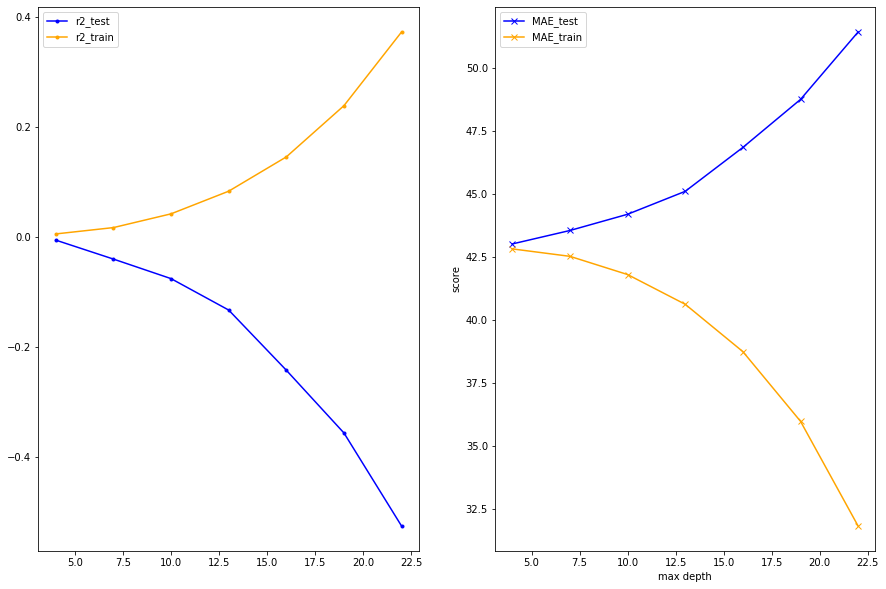

In [10]:
# preprocessing with only mean value
# we use a simple split and just optimize the train part and have a regard to the test part (or validation) in order 
# to avoid overfitting. We do not use grid search because it is too time costly.

train_set, test_set = train_test_split(df_origin, test_size=0.2, random_state=42)
train_set = preprocessing_mean(train_set)
test_set = preprocessing_mean(test_set)
train_target = trains[i][:,indO3]
test_target = tests[i][:,indO3]
train = np.delete(trains[i], indO3, axis=1)
test = np.delete(tests[i], indO3, axis=1)

# maximum depth
vals = np.arange(4,23,3)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = 4, max_depth=x).fit(train, train_target[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_cons.jpeg")

The optimal depth could be 8 to have a compromise between avoiding overfitting and optimize train score. Now we optimize the number of attributes per leaf.

calc split of 271661 points
calc split of 146475 points
calc split of 44445 points
calc split of 657 points
calc split of 439 points
calc split of 275 points
calc split of 82 points
calc split of 57 points
calc split of 6 points
Make it a leaf backup
calc split of 51 points
calc split of 25 points
calc split of 10 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 193 points
calc split of 16 points
Make it a leaf backup
calc split of 177 points
calc split of 57 points
calc split of 120 points
calc split of 164 points
calc split of 97 points
calc split of 87 points
calc split of 16 points
Make it a leaf backup
calc split of 71 points
calc split of 10 points
Make it a leaf backup
calc split of 67 points
calc split of 7 points
Make it a leaf backup
calc split of 60 points
calc split of 9 points
Make it a leaf backup
calc split of 51 points
calc split of 218 points
calc split of 108 points
calc split of 47 points
calc split of 17 points
Make it a leaf 

calc split of 657 points
calc split of 439 points
calc split of 275 points
calc split of 82 points
calc split of 57 points
calc split of 6 points
Make it a leaf backup
calc split of 51 points
calc split of 25 points
calc split of 10 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 193 points
calc split of 16 points
Make it a leaf backup
calc split of 177 points
calc split of 57 points
calc split of 120 points
calc split of 164 points
calc split of 97 points
calc split of 87 points
calc split of 16 points
Make it a leaf backup
calc split of 71 points
calc split of 10 points
Make it a leaf backup
calc split of 67 points
calc split of 7 points
Make it a leaf backup
calc split of 60 points
calc split of 9 points
Make it a leaf backup
calc split of 51 points
calc split of 218 points
calc split of 108 points
calc split of 47 points
calc split of 17 points
Make it a leaf backup
calc split of 30 points
calc split of 16 points
Make it a leaf backup
calc s

Make it a leaf backup
calc split of 51 points
calc split of 218 points
calc split of 108 points
calc split of 47 points
calc split of 17 points
Make it a leaf backup
calc split of 30 points
calc split of 16 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 61 points
calc split of 15 points
Make it a leaf backup
calc split of 46 points
calc split of 37 points
calc split of 9 points
Make it a leaf backup
calc split of 110 points
calc split of 103 points
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 80 points
calc split of 34 points
calc split of 46 points
calc split of 7 points
Make it a leaf backup
calc split of 43788 points
calc split of 274 points
calc split of 225 points
calc split of 16 points
Make it a leaf backup
calc split of 209 points
calc split of 123 points
calc split of 104 points
calc split of 19 points
Make it a leaf backup
calc split of 86 points
calc 

calc split of 47 points
calc split of 17 points
Make it a leaf backup
calc split of 30 points
calc split of 16 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 61 points
calc split of 15 points
Make it a leaf backup
calc split of 46 points
calc split of 37 points
calc split of 9 points
Make it a leaf backup
calc split of 110 points
calc split of 103 points
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 80 points
calc split of 34 points
calc split of 46 points
calc split of 7 points
Make it a leaf backup
calc split of 43788 points
calc split of 274 points
calc split of 225 points
calc split of 16 points
Make it a leaf backup
calc split of 209 points
calc split of 123 points
calc split of 104 points
calc split of 19 points
Make it a leaf backup
calc split of 86 points
calc split of 69 points
calc split of 17 points
Make it a leaf backup
calc split of 49 points
calc sp

Make it a leaf backup
calc split of 110 points
calc split of 103 points
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 80 points
calc split of 34 points
calc split of 46 points
calc split of 7 points
Make it a leaf backup
calc split of 43788 points
calc split of 274 points
calc split of 225 points
calc split of 16 points
Make it a leaf backup
calc split of 209 points
calc split of 123 points
calc split of 104 points
calc split of 19 points
Make it a leaf backup
calc split of 86 points
calc split of 69 points
calc split of 17 points
Make it a leaf backup
calc split of 49 points
calc split of 35 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 43514 points
calc split of 43294 points
calc split of 42516 points
calc split of 42443 poi

calc split of 274 points
calc split of 225 points
calc split of 16 points
Make it a leaf backup
calc split of 209 points
calc split of 123 points
calc split of 104 points
calc split of 19 points
Make it a leaf backup
calc split of 86 points
calc split of 69 points
calc split of 17 points
Make it a leaf backup
calc split of 49 points
calc split of 35 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 43514 points
calc split of 43294 points
calc split of 42516 points
calc split of 42443 points
calc split of 42023 points
calc split of 420 points
calc split of 73 points
calc split of 9 points
Make it a leaf backup
calc split of 64 points
calc split of 778 points
calc split of 654 points
calc split of 567 points
calc split of 87 points
calc split of 124 points
calc split of 30 points
calc split of 94 points
calc split

calc split of 43294 points
calc split of 42516 points
calc split of 42443 points
calc split of 42023 points
calc split of 420 points
calc split of 73 points
calc split of 9 points
Make it a leaf backup
calc split of 64 points
calc split of 778 points
calc split of 654 points
calc split of 567 points
calc split of 87 points
calc split of 124 points
calc split of 30 points
calc split of 94 points
calc split of 220 points
calc split of 26 points
Make it a leaf backup
calc split of 194 points
calc split of 97 points
calc split of 91 points
calc split of 97 points
calc split of 88 points
calc split of 9 points
Make it a leaf backup
calc split of 102030 points
calc split of 13934 points
calc split of 13925 points
calc split of 1331 points
calc split of 137 points
calc split of 11 points
Make it a leaf backup
calc split of 126 points
calc split of 100 points
calc split of 26 points
calc split of 1194 points
calc split of 791 points
calc split of 581 points
calc split of 210 points
calc split 

calc split of 9 points
Make it a leaf backup
calc split of 102030 points
calc split of 13934 points
calc split of 13925 points
calc split of 1331 points
calc split of 137 points
calc split of 11 points
Make it a leaf backup
calc split of 126 points
calc split of 100 points
calc split of 26 points
calc split of 1194 points
calc split of 791 points
calc split of 581 points
calc split of 210 points
calc split of 403 points
calc split of 257 points
calc split of 146 points
calc split of 12594 points
calc split of 323 points
calc split of 130 points
calc split of 103 points
calc split of 27 points
calc split of 193 points
calc split of 24 points
calc split of 169 points
calc split of 12271 points
calc split of 12210 points
calc split of 11338 points
calc split of 872 points
calc split of 61 points
calc split of 20 points
Make it a leaf backup
calc split of 41 points
calc split of 9 points
Make it a leaf backup
calc split of 88096 points
calc split of 2279 points
calc split of 954 points
cal

calc split of 872 points
calc split of 61 points
calc split of 20 points
Make it a leaf backup
calc split of 41 points
calc split of 9 points
Make it a leaf backup
calc split of 88096 points
calc split of 2279 points
calc split of 954 points
calc split of 73 points
calc split of 65 points
calc split of 9 points
Make it a leaf backup
calc split of 56 points
calc split of 881 points
calc split of 539 points
calc split of 168 points
calc split of 371 points
calc split of 342 points
calc split of 16 points
Make it a leaf backup
calc split of 326 points
calc split of 1325 points
calc split of 1306 points
calc split of 367 points
calc split of 56 points
calc split of 311 points
calc split of 939 points
calc split of 403 points
calc split of 536 points
calc split of 19 points
Make it a leaf backup
calc split of 85817 points
calc split of 63 points
calc split of 28 points
calc split of 24 points
Make it a leaf backup
calc split of 35 points
calc split of 21 points
calc split of 16 points
Make 

<Figure size 432x288 with 0 Axes>

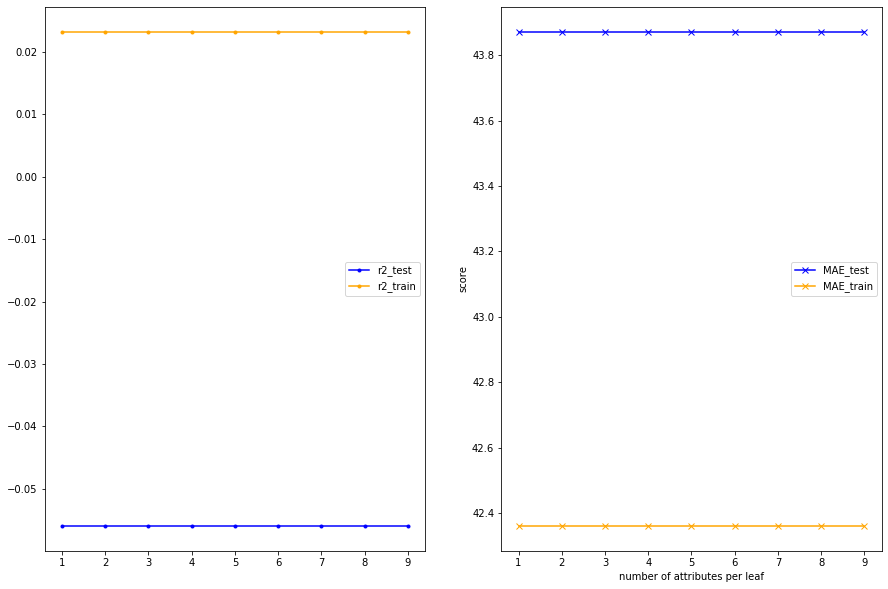

In [11]:
# number of attributes per leaf
vals = np.arange(1,10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = x, max_depth=8).fit(train, train_target[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_cons.jpeg")

The optimal number of attributes per leaf could be 4. We will use these parameters to compare to the other algorithms.

# M5 regressor tree

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 139 points
dim, split 6 0.9779310344827585
calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 43788 points
dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 43514 points
dim, split 5 0.829470198675498
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 

dim, split 8 0.046511627906976744
calc split of 16 points
calc split of 71 points
dim, split 4 0.14146341463414636
calc split of 10 points
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 7 points
calc split of 60 points
dim, split 5 0.6059602649006628
calc split of 9 points
calc split of 51 points
dim, split 6 0.28689655172413786
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 17 points
calc split of 30 points
dim, split 6 0.36827586206896545
calc split of 16 points
calc split of 14 points
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 15 points
calc split of 46 points
dim, split 5 0.7251655629139115
calc split of 37 points
dim, split 2 0.26666666666666666
calc split of 9 points
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split o

dim, split 5 0.4602649006622528
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 496 points
dim, split 8 0.20930232558139536
calc split of 171 points
dim, split 4 0.40325203252032527
calc split of 325 points
dim, split 6 0.1255172413793103
calc split of 768 points
dim, split 4 0.3560975609756098
calc split of 699 points
dim, split 6 0.28965517241379307
calc split of 69 points
dim, split 5 0.821192052980134
calc split of 73 points
dim, split 5 0.9768211920529843
calc split of 38 points
dim, split 3 0.8695652173913043
calc split of 12 points
calc split of 26 points
calc split of 35 points
dim, split 3 0.9130434782608695
calc split of 7 points
calc split of 28 points
dim, split 4 0.06666666666666665
calc split of 83643 points
dim, split 3 0.9130434782608695
calc

dim, split 5 0.829470198675498
calc split of 43294 points
dim, split 6 0.9268965517241379
calc split of 42516 points
dim, split 6 0.9255172413793102
calc split of 42443 points
dim, split 5 0.7930463576158964
calc split of 42023 points
dim, split 5 0.7897350993377472
calc split of 41970 points
dim, split 5 0.26655629139073156
calc split of 4328 points
dim, split 5 0.21192052980132559
calc split of 37642 points
dim, split 5 0.4602649006622528
calc split of 53 points
dim, split 8 0.20930232558139536
calc split of 31 points
dim, split 1 0.2727272727272727
calc split of 22 points
dim, split 2 0.2
calc split of 420 points
dim, split 8 0.32558139534883723
calc split of 363 points
dim, split 6 0.5172413793103448
calc split of 305 points
dim, split 5 0.8228476821192068
calc split of 58 points
dim, split 6 0.553103448275862
calc split of 57 points
dim, split 3 0.43478260869565216
calc split of 25 points
dim, split 0 1.0
calc split of 32 points
dim, split 2 0.26666666666666666
calc split of 73 po

calc split of 101 points
dim, split 8 0.06201550387596899
calc split of 75 points
dim, split 4 0.29268292682926833
calc split of 26 points
dim, split 6 0.47862068965517235
calc split of 67 points
dim, split 2 0.4
calc split of 6 points
calc split of 61 points
dim, split 1 0.9999999999999999
calc split of 371 points
dim, split 6 0.4717241379310344
calc split of 172 points
dim, split 2 0.6
calc split of 103 points
dim, split 1 0.09090909090909091
calc split of 69 points
dim, split 4 0.2959349593495935
calc split of 199 points
dim, split 2 0.4
calc split of 26 points
dim, split 3 0.2608695652173913
calc split of 173 points
dim, split 6 0.536551724137931
calc split of 342 points
dim, split 6 0.3806896551724137
calc split of 16 points
calc split of 326 points
dim, split 1 0.9999999999999999
calc split of 254 points
dim, split 3 0.2608695652173913
calc split of 134 points
dim, split 4 0.2914634146341464
calc split of 120 points
dim, split 8 0.03875968992248062
calc split of 72 points
dim, sp

calc split of 96 points
dim, split 5 0.8509933774834444
calc split of 7 points
calc split of 325 points
dim, split 6 0.1255172413793103
calc split of 6 points
calc split of 319 points
dim, split 5 0.8890728476821188
calc split of 233 points
dim, split 8 0.6124031007751938
calc split of 86 points
dim, split 8 0.3875968992248062
calc split of 768 points
dim, split 4 0.3560975609756098
calc split of 699 points
dim, split 6 0.28965517241379307
calc split of 78 points
dim, split 3 1.0
calc split of 69 points
dim, split 4 0.24349593495934962
calc split of 9 points
calc split of 621 points
dim, split 3 0.6086956521739131
calc split of 36 points
dim, split 6 0.3268965517241379
calc split of 585 points
dim, split 4 0.21300813008130082
calc split of 69 points
dim, split 5 0.821192052980134
calc split of 42 points
dim, split 5 0.8145695364238428
calc split of 26 points
dim, split 8 0.18604651162790697
calc split of 16 points
calc split of 27 points
dim, split 8 0.2945736434108527
calc split of 17

calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 57 points
dim, split 4 0.1772357723577236
calc split of 6 points
calc split of 51 points
dim, split 8 0.11627906976744186
calc split of 20 points
calc split of 31 points
dim, split 8 0.22480620155038758
calc split of 22 points
dim, split 1 0.09090909090909091
calc split of 6 points
calc split of 16 points
calc split of 9 points
calc split of 25 points
dim, split 4 0.19837398373983742
calc split of 10 points
calc split of 15 points
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 16 points
calc split of 177 points
dim, split 8 0.06201550387596899
calc split of 57 points
dim, split 4 0.20650406504065041
calc split of 49 points
dim, split

dim, split 4 0.8048780487804879
calc split of 654 points
dim, split 8 0.11627906976744186
calc split of 567 points
dim, split 3 0.4782608695652174
calc split of 541 points
dim, split 4 0.7300813008130083
calc split of 53 points
dim, split 5 0.30132450331126037
calc split of 44 points
dim, split 6 0.9379310344827585
calc split of 30 points
dim, split 5 0.20033112582781598
calc split of 14 points
calc split of 9 points
calc split of 488 points
dim, split 5 0.25
calc split of 151 points
dim, split 2 0.1
calc split of 89 points
dim, split 5 0.2235099337748352
calc split of 62 points
dim, split 6 0.9324137931034482
calc split of 337 points
dim, split 6 0.9434482758620689
calc split of 282 points
dim, split 6 0.9420689655172413
calc split of 55 points
dim, split 8 0.07751937984496124
calc split of 26 points
dim, split 6 0.9310344827586207
calc split of 13 points
calc split of 13 points
calc split of 87 points
dim, split 6 0.9351724137931033
calc split of 70 points
dim, split 2 0.033333333333

dim, split 5 0.4735099337748352
calc split of 323 points
dim, split 8 0.06976744186046512
calc split of 130 points
dim, split 2 0.8666666666666667
calc split of 103 points
dim, split 4 0.28455284552845533
calc split of 95 points
dim, split 5 0.4701986754966896
calc split of 81 points
dim, split 3 0.30434782608695654
calc split of 56 points
dim, split 4 0.20975609756097563
calc split of 8 points
calc split of 48 points
dim, split 2 0.8333333333333334
calc split of 25 points
dim, split 2 0.7666666666666667
calc split of 18 points
calc split of 7 points
calc split of 14 points
calc split of 8 points
calc split of 27 points
dim, split 8 0.06201550387596899
calc split of 23 points
dim, split 8 0.05426356589147287
calc split of 17 points
calc split of 6 points
calc split of 4 points
calc split of 193 points
dim, split 4 0.23414634146341465
calc split of 24 points
dim, split 2 0.7333333333333333
calc split of 8 points
calc split of 16 points
calc split of 169 points
dim, split 8 0.16279069767

dim, split 5 0.8079470198675516
calc split of 236 points
dim, split 8 0.1937984496124031
calc split of 214 points
dim, split 2 0.9
calc split of 150 points
dim, split 6 0.5503448275862068
calc split of 64 points
dim, split 3 0.043478260869565216
calc split of 22 points
dim, split 5 0.788079470198678
calc split of 15 points
calc split of 7 points
calc split of 18 points
calc split of 57 points
dim, split 2 0.7666666666666667
calc split of 23 points
dim, split 6 0.5255172413793103
calc split of 16 points
calc split of 7 points
calc split of 34 points
dim, split 4 0.2943089430894309
calc split of 8 points
calc split of 26 points
calc split of 939 points
dim, split 4 0.2934959349593496
calc split of 403 points
dim, split 5 0.85430463576159
calc split of 372 points
dim, split 6 0.4151724137931034
calc split of 173 points
dim, split 6 0.28689655172413786
calc split of 17 points
calc split of 156 points
dim, split 5 0.6556291390728504
calc split of 13 points
calc split of 143 points
dim, spli

calc split of 273 points
dim, split 6 0.5379310344827586
calc split of 69 points
dim, split 3 0.8260869565217391
calc split of 10 points
calc split of 1047 points
dim, split 4 0.4520325203252033
calc split of 57 points
dim, split 6 0.5255172413793103
calc split of 48 points
dim, split 6 0.43034482758620685
calc split of 9 points
calc split of 990 points
dim, split 8 0.08527131782945736
calc split of 82 points
dim, split 4 0.6227642276422765
calc split of 908 points
dim, split 3 0.9565217391304348
calc split of 2553 points
dim, split 5 0.5413907284768236
calc split of 502 points
dim, split 6 0.3751724137931034
calc split of 73 points
dim, split 8 0.08527131782945736
calc split of 10 points
calc split of 63 points
dim, split 8 0.16279069767441862
calc split of 429 points
dim, split 1 0.09090909090909091
calc split of 113 points
dim, split 4 0.4764227642276423
calc split of 316 points
dim, split 4 0.3788617886178862
calc split of 2051 points
dim, split 4 0.5414634146341464
calc split of 1

dim, split 8 0.6124031007751938
calc split of 213 points
dim, split 6 0.2386206896551723
calc split of 89 points
dim, split 6 0.1806896551724137
calc split of 124 points
dim, split 5 0.821192052980134
calc split of 20 points
calc split of 86 points
dim, split 8 0.3875968992248062
calc split of 62 points
dim, split 6 0.15172413793103445
calc split of 32 points
dim, split 6 0.13655172413793099
calc split of 30 points
dim, split 8 0.3488372093023256
calc split of 24 points
dim, split 3 0.7391304347826086
calc split of 6 points
calc split of 18 points
calc split of 768 points
dim, split 4 0.3560975609756098
calc split of 699 points
dim, split 6 0.28965517241379307
calc split of 78 points
dim, split 3 1.0
calc split of 69 points
dim, split 4 0.24349593495934962
calc split of 15 points
calc split of 54 points
dim, split 3 0.8260869565217391
calc split of 26 points
dim, split 2 0.9999999999999999
calc split of 28 points
dim, split 0 0.75
calc split of 9 points
calc split of 621 points
dim, sp

dim, split 1 0.6363636363636364
calc split of 15 points
calc split of 16 points
calc split of 32 points
dim, split 8 0.15503875968992248
calc split of 15 points
calc split of 17 points
calc split of 9 points
calc split of 22753 points
dim, split 4 0.8666666666666667
calc split of 22737 points
dim, split 4 0.34471544715447155
calc split of 2940 points
dim, split 6 0.25931034482758614
calc split of 66 points
dim, split 8 0.20930232558139536
calc split of 8 points
calc split of 58 points
dim, split 6 0.2510344827586206
calc split of 31 points
dim, split 4 0.2829268292682927
calc split of 8 points
calc split of 23 points
dim, split 2 0.9666666666666667
calc split of 14 points
calc split of 9 points
calc split of 27 points
dim, split 5 0.675496688741724
calc split of 18 points
calc split of 9 points
calc split of 2874 points
dim, split 4 0.2650406504065041
calc split of 760 points
dim, split 6 0.45517241379310336
calc split of 558 points
dim, split 8 0.07751937984496124
calc split of 220 po

prune left node at level 12
prune right node at level 12
prune left node at level 11
prune left node at level 9
prune right node at level 12
prune left node at level 12
prune left node at level 12
prune right node at level 11
prune right node at level 12
prune left node at level 12
prune right node at level 12
prune right node at level 7
prune left node at level 10
prune right node at level 11
prune right node at level 11
prune left node at level 12
prune right node at level 12
prune left node at level 12
prune left node at level 11
prune left node at level 12
prune right node at level 11
prune left node at level 10
prune right node at level 9
prune left node at level 7
prune left node at level 11
prune left node at level 9
prune left node at level 12
prune left node at level 11
prune right node at level 12
prune right node at level 11
prune left node at level 12
prune right node at level 12
prune right node at level 12
prune right node at level 10
prune right node at level 10
prune ri

calc split of 321 points
dim, split 5 0.17218543046357837
calc split of 161 points
dim, split 4 0.8422764227642277
calc split of 86 points
dim, split 5 0.10099337748344439
calc split of 75 points
dim, split 5 0.16887417218543277
calc split of 160 points
dim, split 5 0.20695364238410718
calc split of 129 points
dim, split 6 0.913103448275862
calc split of 31 points
dim, split 8 0.13953488372093023
calc split of 2399 points
dim, split 6 0.793103448275862
calc split of 730 points
dim, split 2 0.23333333333333334
calc split of 540 points
dim, split 8 0.40310077519379844
calc split of 519 points
dim, split 8 0.031007751937984496
calc split of 21 points
dim, split 3 0.30434782608695654
calc split of 190 points
dim, split 4 0.6422764227642277
calc split of 45 points
dim, split 0 0.5
calc split of 145 points
dim, split 5 0.241721854304636
calc split of 1669 points
dim, split 6 0.7944827586206895
calc split of 19 points
calc split of 1650 points
dim, split 2 0.06666666666666668
calc split of 35

dim, split 3 0.21739130434782608
calc split of 23 points
dim, split 0 1.0
calc split of 14 points
calc split of 9 points
calc split of 25 points
dim, split 3 0.43478260869565216
calc split of 19 points
dim, split 0 1.0
calc split of 10 points
calc split of 9 points
calc split of 6 points
calc split of 43 points
dim, split 0 1.0
calc split of 32 points
dim, split 1 0.9999999999999999
calc split of 24 points
dim, split 4 0.23414634146341465
calc split of 10 points
calc split of 14 points
calc split of 8 points
calc split of 11 points
calc split of 97 points
dim, split 5 0.8824503311258312
calc split of 88 points
dim, split 1 0.1818181818181818
calc split of 28 points
dim, split 5 0.870860927152318
calc split of 21 points
calc split of 7 points
calc split of 60 points
dim, split 4 0.29756097560975614
calc split of 8 points
calc split of 52 points
dim, split 1 0.9999999999999999
calc split of 33 points
dim, split 2 0.26666666666666666
calc split of 15 points
calc split of 18 points
calc sp

calc split of 16 points
calc split of 169 points
dim, split 8 0.16279069767441862
calc split of 136 points
dim, split 4 0.24227642276422767
calc split of 12 points
calc split of 124 points
dim, split 6 0.38344827586206887
calc split of 32 points
dim, split 6 0.353103448275862
calc split of 17 points
calc split of 15 points
calc split of 92 points
dim, split 6 0.47862068965517235
calc split of 58 points
dim, split 6 0.4386206896551723
calc split of 23 points
dim, split 2 0.3666666666666667
calc split of 8 points
calc split of 15 points
calc split of 35 points
dim, split 3 0.34782608695652173
calc split of 27 points
dim, split 1 0.09090909090909091
calc split of 8 points
calc split of 34 points
dim, split 6 0.536551724137931
calc split of 29 points
dim, split 3 0.34782608695652173
calc split of 20 points
calc split of 9 points
calc split of 5 points
calc split of 33 points
dim, split 4 0.2666666666666667
calc split of 6 points
calc split of 27 points
calc split of 12271 points
dim, split

dim, split 2 0.4
calc split of 6 points
calc split of 61 points
dim, split 1 0.9999999999999999
calc split of 53 points
dim, split 2 0.5
calc split of 26 points
dim, split 3 0.3913043478260869
calc split of 18 points
calc split of 8 points
calc split of 27 points
dim, split 0 0.75
calc split of 22 points
calc split of 5 points
calc split of 8 points
calc split of 371 points
dim, split 6 0.4717241379310344
calc split of 172 points
dim, split 2 0.6
calc split of 103 points
dim, split 1 0.09090909090909091
calc split of 38 points
dim, split 5 0.5562913907284788
calc split of 23 points
dim, split 5 0.5397350993377508
calc split of 15 points
calc split of 8 points
calc split of 15 points
calc split of 65 points
dim, split 5 0.5728476821192068
calc split of 52 points
dim, split 1 0.9999999999999999
calc split of 35 points
dim, split 8 0.06201550387596899
calc split of 8 points
calc split of 27 points
calc split of 17 points
calc split of 13 points
calc split of 69 points
dim, split 4 0.29593

calc split of 85817 points
dim, split 6 0.25379310344827577
calc split of 63 points
dim, split 2 0.5333333333333333
calc split of 28 points
dim, split 3 0.5217391304347826
calc split of 24 points
calc split of 4 points
calc split of 35 points
dim, split 6 0.24413793103448272
calc split of 21 points
dim, split 4 0.391869918699187
calc split of 16 points
calc split of 5 points
calc split of 14 points
calc split of 85754 points
dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 83695 points
dim, split 5 0.6970198675496704
calc split of 80372 points
dim, split 8 0.3875968992248062
calc split of 79028 points
dim, split 5 0.6556291390728504
calc split of 75348 points
dim, split 5 0.6407284768211952
calc split of 73859 points
dim, split 7 0.028965517241379312
calc split of 73222 points
dim, split 7 0.016551724137931035
calc split of 72768 points
dim, split 7 0.009655172413793102
calc split of 72158 points
dim, split 

dim, split 4 0.33495934959349594
calc split of 15 points
calc split of 19 points
dim, split 3 0.21739130434782608
calc split of 293 points
dim, split 2 0.9333333333333333
calc split of 248 points
dim, split 4 0.33495934959349594
calc split of 101 points
dim, split 4 0.3089430894308943
calc split of 15 points
calc split of 86 points
dim, split 4 0.31544715447154476
calc split of 34 points
dim, split 5 0.8145695364238428
calc split of 9 points
calc split of 25 points
dim, split 2 0.9
calc split of 52 points
dim, split 2 0.7333333333333333
calc split of 24 points
dim, split 2 0.43333333333333335
calc split of 28 points
dim, split 5 0.7831125827814596
calc split of 147 points
dim, split 5 0.7930463576158964
calc split of 71 points
dim, split 4 0.3463414634146342
calc split of 23 points
dim, split 0 0.5
calc split of 9 points
calc split of 14 points
calc split of 48 points
dim, split 5 0.788079470198678
calc split of 31 points
dim, split 0 0.5
calc split of 17 points
calc split of 76 points

dim, split 3 0.9130434782608695
calc split of 26251 points
dim, split 4 0.24065040650406505
calc split of 245 points
dim, split 5 0.5728476821192068
calc split of 7 points
calc split of 238 points
dim, split 2 0.6666666666666666
calc split of 193 points
dim, split 4 0.18048780487804877
calc split of 10 points
calc split of 183 points
dim, split 6 0.2744827586206896
calc split of 68 points
dim, split 8 0.3565891472868217
calc split of 43 points
dim, split 3 0.8260869565217391
calc split of 18 points
calc split of 25 points
dim, split 2 0.26666666666666666
calc split of 25 points
dim, split 8 0.5116279069767442
calc split of 17 points
calc split of 8 points
calc split of 115 points
dim, split 5 0.7036423841059651
calc split of 72 points
dim, split 2 0.6
calc split of 62 points
dim, split 4 0.19024390243902442
calc split of 10 points
calc split of 43 points
dim, split 6 0.39172413793103444
calc split of 14 points
calc split of 29 points
dim, split 4 0.23902439024390246
calc split of 45 po

dim, split 5 0.4602649006622528
calc split of 98 points
dim, split 4 0.6130081300813008
calc split of 89 points
dim, split 8 0.09302325581395349
calc split of 38 points
dim, split 0 0.5
calc split of 15 points
calc split of 23 points
dim, split 2 0.6333333333333333
calc split of 13 points
calc split of 10 points
calc split of 51 points
dim, split 3 0.6956521739130435
calc split of 11 points
calc split of 40 points
dim, split 7 0.019310344827586205
calc split of 21 points
calc split of 19 points
calc split of 9 points
calc split of 280 points
dim, split 2 0.6666666666666666
calc split of 188 points
dim, split 5 0.6390728476821224
calc split of 181 points
dim, split 3 1.0
calc split of 140 points
dim, split 5 0.4817880794701992
calc split of 50 points
dim, split 5 0.4801324503311264
calc split of 43 points
dim, split 2 0.6333333333333333
calc split of 7 points
calc split of 90 points
dim, split 8 0.05426356589147287
calc split of 7 points
calc split of 83 points
dim, split 7 0.0179310344

calc split of 23 points
dim, split 4 0.7642276422764229
calc split of 6 points
calc split of 17 points
calc split of 9 points
calc split of 18 points
calc split of 264 points
dim, split 6 0.6055172413793103
calc split of 7 points
calc split of 257 points
dim, split 6 0.8303448275862069
calc split of 183 points
dim, split 5 0.09933774834437159
calc split of 47 points
dim, split 8 0.08527131782945736
calc split of 136 points
dim, split 5 0.10099337748344439
calc split of 74 points
dim, split 4 0.7479674796747968
calc split of 53 points
dim, split 3 0.8695652173913043
calc split of 21 points
calc split of 649 points
dim, split 5 0.19701986754967038
calc split of 628 points
dim, split 3 0.7391304347826086
calc split of 399 points
dim, split 6 0.536551724137931
calc split of 69 points
dim, split 6 0.5213793103448275
calc split of 52 points
dim, split 2 0.3333333333333333
calc split of 33 points
dim, split 4 0.7463414634146341
calc split of 19 points
dim, split 4 0.8520325203252034
calc spli

calc split of 10 points
calc split of 25 points
dim, split 1 0.8181818181818182
calc split of 57 points
dim, split 0 0.75
calc split of 46 points
dim, split 2 0.4
calc split of 15 points
calc split of 31 points
dim, split 2 0.9999999999999999
calc split of 19 points
calc split of 12 points
calc split of 11 points
calc split of 509 points
dim, split 4 0.7056910569105692
calc split of 419 points
dim, split 4 0.6991869918699187
calc split of 392 points
dim, split 4 0.6292682926829269
calc split of 90 points
dim, split 5 0.3145695364238428
calc split of 14 points
calc split of 76 points
dim, split 5 0.3162251655629156
calc split of 9 points
calc split of 67 points
dim, split 6 0.8275862068965517
calc split of 56 points
dim, split 1 0.8181818181818182
calc split of 9 points
calc split of 47 points
dim, split 8 0.09302325581395349
calc split of 11 points
calc split of 302 points
dim, split 7 0.18482758620689654
calc split of 240 points
dim, split 5 0.3261589403973524
calc split of 131 points

dim, split 5 0.5927152317880804
calc split of 36 points
dim, split 6 0.4703448275862068
calc split of 41 points
dim, split 4 0.4504065040650407
calc split of 99 points
dim, split 8 0.5116279069767442
calc split of 79 points
dim, split 3 0.9565217391304348
calc split of 11 points
calc split of 68 points
dim, split 4 0.43252032520325207
calc split of 62 points
dim, split 0 0.75
calc split of 56 points
dim, split 6 0.32551724137931026
calc split of 6 points
calc split of 6 points
calc split of 20 points
calc split of 38 points
dim, split 5 0.5761589403973524
calc split of 15 points
calc split of 23 points
dim, split 4 0.551219512195122
calc split of 15 points
calc split of 8 points
calc split of 18715 points
dim, split 6 0.5517241379310344
calc split of 501 points
dim, split 5 0.4701986754966896
calc split of 105 points
dim, split 8 0.1937984496124031
calc split of 81 points
dim, split 5 0.4602649006622528
calc split of 72 points
dim, split 5 0.4354304635761608
calc split of 66 points
dim

prune right node at level 14
prune left node at level 14
prune right node at level 14
prune right node at level 14
prune right node at level 14
prune right node at level 14
prune left node at level 13
prune left node at level 14
prune right node at level 11
prune right node at level 11
prune left node at level 13
prune left node at level 14
prune left node at level 14
prune right node at level 14
prune right node at level 14
prune left node at level 14
prune left node at level 13
prune right node at level 13
prune left node at level 14
prune right node at level 14
prune right node at level 13
prune left node at level 13
prune left node at level 14
prune left node at level 11
prune left node at level 9
prune right node at level 13
prune left node at level 13
prune right node at level 12
prune right node at level 14
prune left node at level 14
prune right node at level 14
prune right node at level 14
prune left node at level 13
prune left node at level 12
prune left node at level 14
prun

<Figure size 432x288 with 0 Axes>

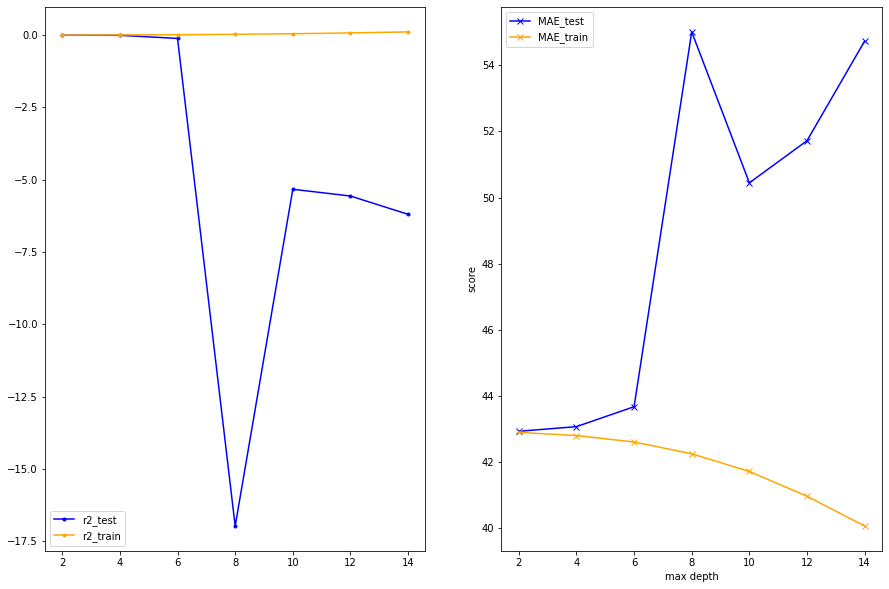

In [12]:
# max depth
vals = np.arange(2,15,2)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=x,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_M5.jpeg")

It seems that the best value is 4 because we overfit after that.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 43788 points
dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 43514 points
dim, split 5 0.829470198675498
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 9 points
calc split of 88096 points
dim, split 4 0.2995934959349594
calc split of 2279 points
dim, split 5 0.6390728476821224
calc split of 85817 points
dim, split 6 0.25379310344827577
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 43788 points
dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 43514 points
dim, split 5 0.829470198675498
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 9 points
calc split of 88096 points
dim, split 4 0.2995934959349594
calc split of 2279 points
dim, split 5 0.6390728476821224
calc split of 85817 points
dim, split 6 0.25379310344827577
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41

<Figure size 432x288 with 0 Axes>

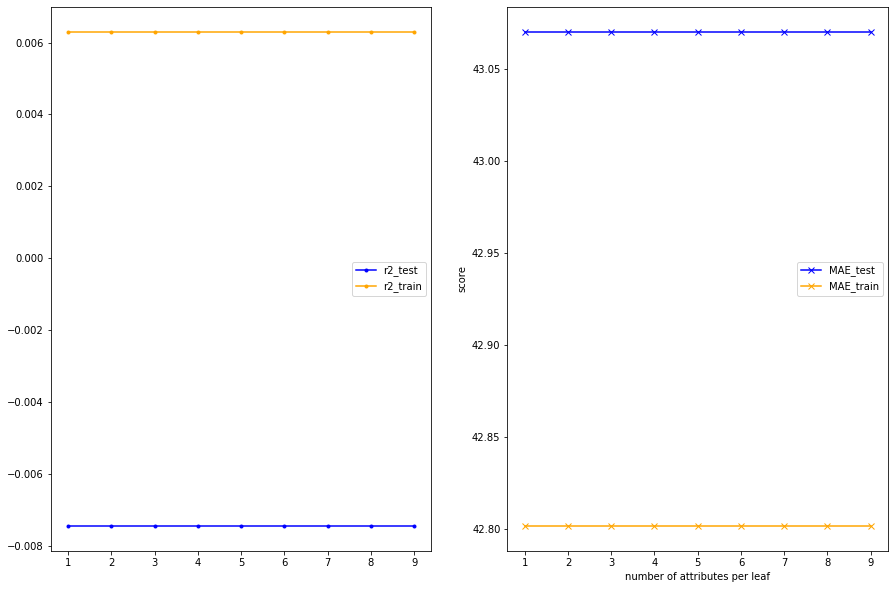

In [16]:
# number of attributes per leaf
vals = np.arange(1,10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=x, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_M5.jpeg")

It seems not to change a lot, let's take the default value.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 43788 points
dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 43514 points
dim, split 5 0.829470198675498
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 9 points
calc split of 88096 points
dim, split 4 0.2995934959349594
calc split of 2279 points
dim, split 5 0.6390728476821224
calc split of 85817 points
dim, split 6 0.25379310344827577
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41

<Figure size 432x288 with 0 Axes>

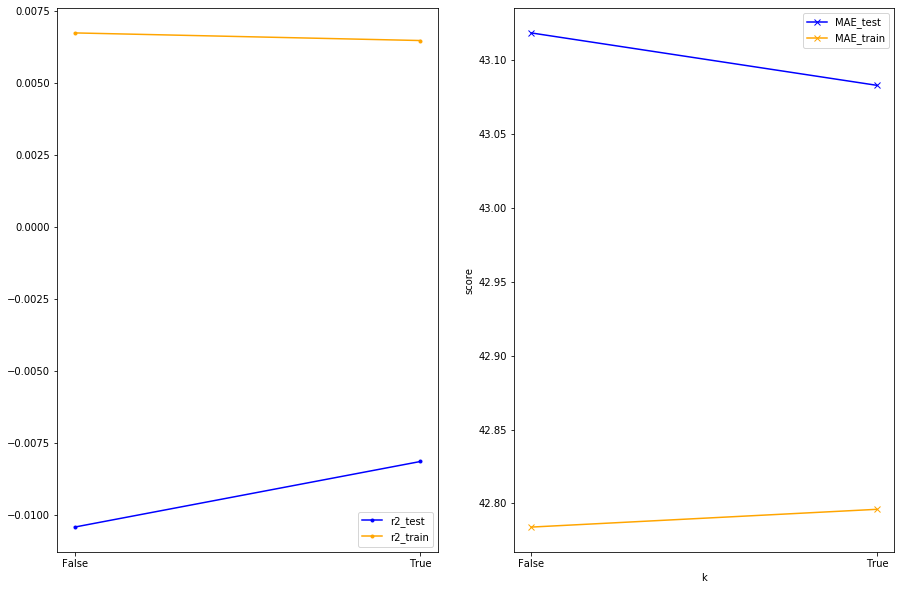

In [17]:
# smoothing
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=4,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/smoothing_M5.jpeg")

We need smoothing to avoid overfitting.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

<Figure size 432x288 with 0 Axes>

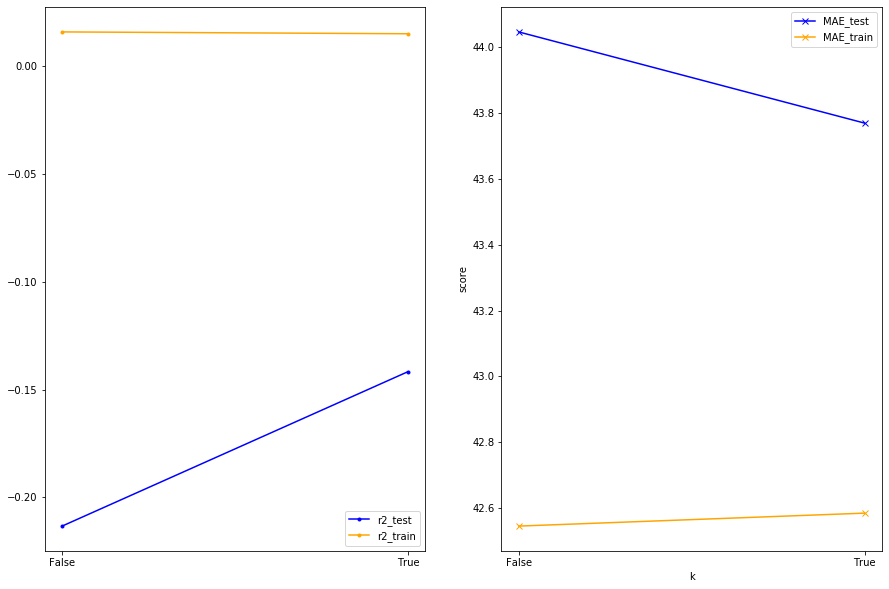

In [18]:
# pruning
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/pruning_M5.jpeg")

We need pruning to avoid overfitting.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 225 points
dim, split 5 0.5397350993377508
calc split of 16 points
calc split of 209 points
dim, split 4 0.21138211382113822
calc split of 49 points
dim, split 0 0.75
calc split of 35 points
dim, split 6 0.47310344827586204
calc split of 14 points
calc split of 43514 points
dim, split 5 0.829470198675498
calc split of 43294 points
dim, split 6 0.9268965517241379
calc split of 42516 points
dim, split 6 0.9255172413793102
calc split of 778 points
dim, split 4 0.8048780487804879
calc split of 220 points
dim, split 8 0.07751937984496124
calc split of 26 points
calc split of 194 points
dim, split 4 0.2943089430894309
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 1331 points
dim, split 8 0.046511627906976744
calc split of 137 points
dim, split 6 0.33655172413

dim, split 3 0.9130434782608695
calc split of 60890 points
dim, split 1 0.4545454545454545
calc split of 7982 points
dim, split 8 0.6434108527131783
calc split of 7964 points
dim, split 7 0.07172413793103448
calc split of 18 points
calc split of 52908 points
dim, split 4 0.9528455284552847
calc split of 52899 points
dim, split 7 0.034482758620689655
calc split of 9 points
calc split of 22753 points
dim, split 4 0.8666666666666667
calc split of 22737 points
dim, split 4 0.34471544715447155
calc split of 2940 points
dim, split 6 0.25931034482758614
calc split of 19797 points
dim, split 8 0.5348837209302326
calc split of 16 points
calc split of 139 points
dim, split 6 0.9779310344827585
calc split of 72 points
dim, split 4 0.8276422764227643
calc split of 47 points
dim, split 4 0.8081300813008131
calc split of 26 points
dim, split 8 0.06201550387596899
calc split of 11 points
calc split of 15 points
calc split of 21 points
calc split of 25 points
dim, split 5 0.2235099337748352
calc split

dim, split 6 0.9255172413793102
calc split of 778 points
dim, split 4 0.8048780487804879
calc split of 220 points
dim, split 8 0.07751937984496124
calc split of 26 points
calc split of 194 points
dim, split 4 0.2943089430894309
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 1331 points
dim, split 8 0.046511627906976744
calc split of 137 points
dim, split 6 0.336551724137931
calc split of 1194 points
dim, split 4 0.2682926829268293
calc split of 12594 points
dim, split 5 0.4735099337748352
calc split of 323 points
dim, split 8 0.06976744186046512
calc split of 12271 points
dim, split 5 0.9519867549668923
calc split of 9 points
calc split of 88096 points
dim, split 4 0.2995934959349594
calc split of 2279 points
dim, split 5 0.6390728476821224
calc split of 954 points
dim, split 6 0.3613793103448275
calc split of 73 points
dim, split 4 0.2910569105691057
calc 

dim, split 4 0.8666666666666667
calc split of 22737 points
dim, split 4 0.34471544715447155
calc split of 2940 points
dim, split 6 0.25931034482758614
calc split of 19797 points
dim, split 8 0.5348837209302326
calc split of 16 points
calc split of 139 points
dim, split 6 0.9779310344827585
calc split of 72 points
dim, split 4 0.8276422764227643
calc split of 47 points
dim, split 4 0.8081300813008131
calc split of 26 points
dim, split 8 0.06201550387596899
calc split of 11 points
calc split of 15 points
calc split of 21 points
calc split of 25 points
dim, split 5 0.2235099337748352
calc split of 8 points
calc split of 17 points
calc split of 67 points
dim, split 3 0.8260869565217391
calc split of 30 points
dim, split 8 0.16279069767441862
calc split of 16 points
calc split of 14 points
calc split of 37 points
dim, split 3 0.9565217391304348
calc split of 28 points
dim, split 3 0.8695652173913043
calc split of 7 points
calc split of 21 points
calc split of 9 points
calc split of 271661 p

<Figure size 432x288 with 0 Axes>

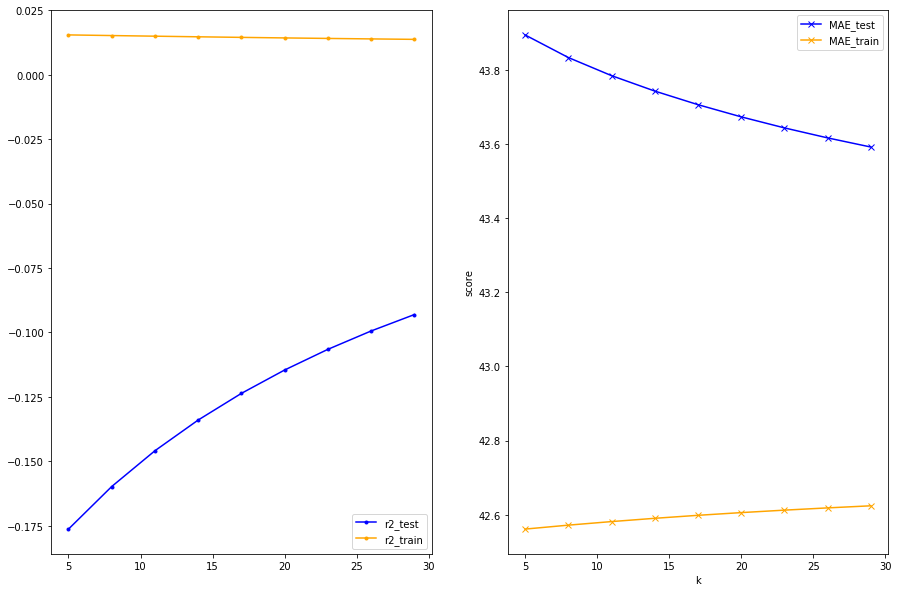

In [19]:
# k
vals = np.arange(5,31,3)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=x,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/k_M5.jpeg")


We will take k=30

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

<Figure size 432x288 with 0 Axes>

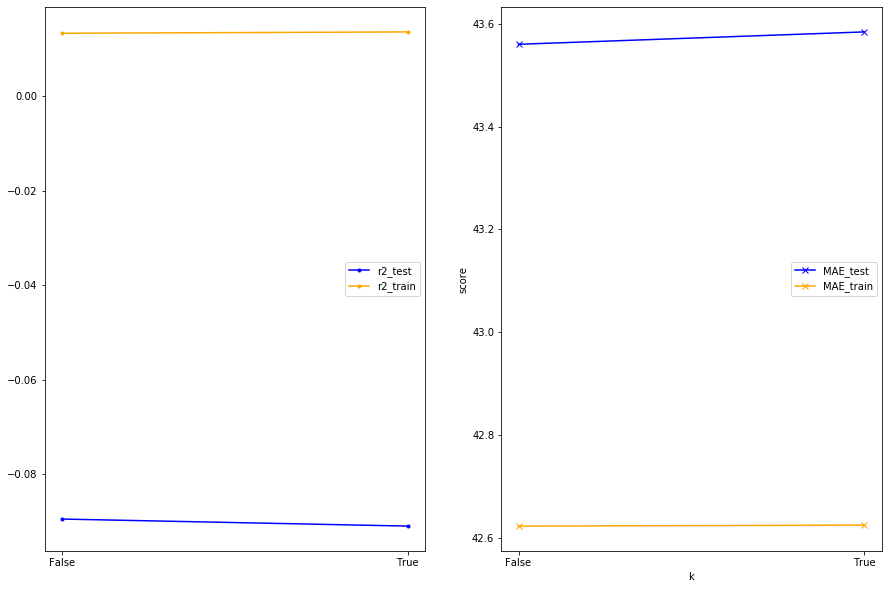

In [20]:
# optimize models
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=30,pruning=True,optimize_models=x,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/opti_model_M5.jpeg")

There is no real difference so we will still optimize models.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

<Figure size 432x288 with 0 Axes>

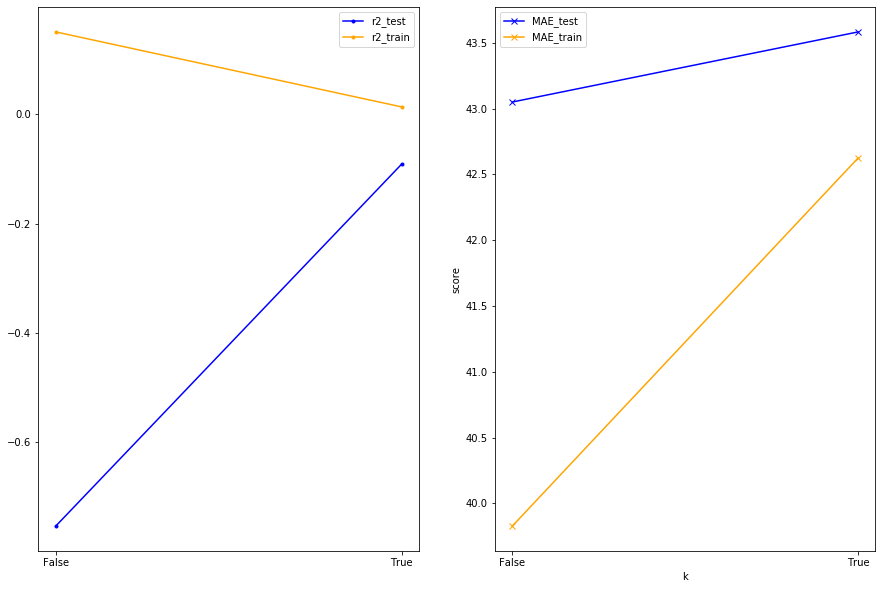

In [21]:
# incremental fit
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=30,pruning=True,optimize_models=True,incremental_fit=x).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/incr_fit_M5.jpeg")

We need incremental fit to avoid overfitting.

# Compare with existing algorithms

We can notice that the difference can be ignored, so we will just delete the samples with missing data during the preprocessing phase.

In [ ]:
import timeit

kf = KFold(n_splits=10, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2, const_regressor_sklearn_r2_model, linear_regressor_r2, random_forest_regressor_r2, extra_tree_r2 = [], [], [], [], [], []
M5regressor_MAE_model, const_regressor_MAE, const_regressor_sklearn_MAE_model, linear_regressor_MAE, random_forest_regressor_MAE, extra_tree_MAE = [], [], [], [], [], []
times = {"M5":-1, "cons":-1, "cons_sk":-1, "linear":-1, "random_forest":-1, "extratree":-1}

# We split the data and apply the pre-processing

for train_index, test_index in split:
    
        train_set = preprocessing_mean(df_origin.iloc[train_index])
        test_set = preprocessing_mean(df_origin.iloc[test_index])
        y_train = trains[i][:,indO3]
        y_test = tests[i][:,indO3]
        X_train = np.delete(trains[i], indO3, axis=1)
        X_test = np.delete(tests[i], indO3, axis=1)

        #M5 regressor tree own
        start = timeit.default_timer()
        reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
        M5regressor_r2_model.append(r2_score(y_test, reg.predict(X_test)))
        M5regressor_MAE_model.append(mean_absolute_error(y_test, reg.predict(X_test)))
        times["M5"] = timeit.default_timer()-start
        
        #Constant regressor tree own
        start = timeit.default_timer()
        reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
        const_regressor_r2.append(r2_score(y_test, reg2.predict(X_test)))
        const_regressor_MAE.append(mean_absolute_error(y_test, reg2.predict(X_test)))
        times["cons"] = timeit.default_timer()-start
        
        #Constant regressor tree SKlearn #SAME PARAMETERS AS OURS?
        start = timeit.default_timer()
        const_regressor_sklearn = tree.DecisionTreeRegressor(min_samples_leaf=4, max_depth=8, random_state=42).fit(X_train, y_train)
        const_regressor_sklearn_r2_model.append(r2_score(y_test, const_regressor_sklearn.predict(X_test)))
        const_regressor_sklearn_MAE_model.append(mean_absolute_error(y_test, const_regressor_sklearn.predict(X_test)))
        times["cons_sk"] = timeit.default_timer()-start
        #Linear regression sklearn
        start = timeit.default_timer()
        linear_regressor = LinearRegression().fit(X_train, y_train)
        linear_regressor_r2.append(r2_score(y_test, linear_regressor.predict(X_test)))
        linear_regressor_MAE.append(mean_absolute_error(y_test, linear_regressor.predict(X_test)))
        times["linear"] = timeit.default_timer()-start
        # Random forrest regressor
        start = timeit.default_timer()
        random_forest_regressor = RandomForestRegressor(max_depth=8, min_samples_split=4, random_state=42).fit(X_train, y_train)
        random_forest_regressor_r2.append(r2_score(y_test, random_forest_regressor.predict(X_test)))
        random_forest_regressor_MAE.append(mean_absolute_error(y_test, random_forest_regressor.predict(X_test)))
        times["random_forest"] = timeit.default_timer()-start
        #Extra tree regressor
        start = timeit.default_timer()
        extra_tree_regressor = ExtraTreeRegressor(max_depth=8, random_state=42).fit(X_train, y_train)
        extra_tree_r2.append(r2_score(y_test, extra_tree_regressor .predict(X_test)))
        extra_tree_MAE.append(mean_absolute_error(y_test, extra_tree_regressor .predict(X_test)))
        times["extratree"] = timeit.default_timer()-start


m5_r2 = np.mean(M5regressor_r2_model)
cons_r2 = np.mean(const_regressor_r2)                                           
cons_sklearn_r2 = np.mean(const_regressor_sklearn_r2_model)   
linear_r2 = np.mean(linear_regressor_r2)
random_r2 =np.mean(random_forest_regressor_r2)
extra_r2= np.mean(extra_tree_r2)
m5_MAE = np.mean(M5regressor_MAE_model)
cons_MAE = np.mean(const_regressor_MAE)                                           
cons_sklearn_MAE = np.mean(const_regressor_sklearn_MAE_model)   
linear_MAE = np.mean(linear_regressor_MAE)
random_MAE =np.mean(random_forest_regressor_MAE)
extra_MAE = np.mean(extra_tree_MAE)
print("m5 r2", m5_r2, "MAE", m5_MAE )
print("cons r2",cons_r2, "MAE", cons_MAE  )
print("cons_sklearn r2", cons_sklearn_r2, "MAE", cons_sklearn_MAE) 
print("linear r2", linear_r2, "MAE", linear_MAE)
print("random r2", random_r2, "MAE", random_MAE)
print("extra r2", extra_r2, "MAE", extra_MAE)
print(times)

In [ ]:
objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
r2score = [m5_r2,cons_r2,cons_sklearn_r2,linear_r2,random_r2,1]

plt.bar(y_pos, r2score, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('R2 score')
plt.title('R2 score per model')
plt.savefig("../figures/airquality/r2scores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
MAEscore = [m5_MAE,cons_MAE,cons_sklearn_MAE,linear_MAE,random_MAE,1]

plt.bar(y_pos, MAEscore, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('MAE score')
plt.title('MAE score per model')
plt.savefig("../figures/airquality/MAEscores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))

plt.bar(y_pos, times.values(), align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Time (s)')
plt.title('Execution time per model')